In [ ]:
 import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN. 



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

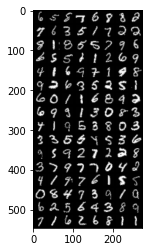

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and Leaky ReLU, 
    except the last block (which is only followed by tanh)
    '''
    modules = []
    modules.append(nn.ConvTranspose2d(channels_in,channels_out,kernel,stride=stride,padding=padding,bias=False))
    if last_layer:
        modules.append(nn.Tanh())
    else:
        modules.append(nn.BatchNorm2d(channels_out))
        modules.append(nn.LeakyReLU(negative_slope=0.2))

    return nn.Sequential(*modules)


class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        filters = [nz,128,64,ngf,nchannels]
        padding = [0,1,1,1]
        stride = [1,2,2,2]
        last_layer = [False,False,False,True]
        self.model = nn.Sequential(*[get_upscaling_block(filters[x-1],filters[x],4,stride[x-1],padding[x-1],last_layer[x-1]) for x in range(1,len(filters))])
        
        ###################
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 100
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
print(G(z).shape)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

torch.Size([128, 1, 32, 32])


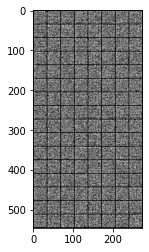

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    modules = []
    modules.append(nn.Conv2d(channels_in,channels_out,kernel,stride=stride,padding=padding,bias=False))
    if is_last:
      modules.append(nn.Sigmoid())
    
    elif not use_batch_norm:
      modules.append(nn.LeakyReLU(negative_slope=0.2))
    
    else:
      modules.append(nn.BatchNorm2d(channels_out))
      modules.append(nn.LeakyReLU(negative_slope=0.2))

    return nn.Sequential(*modules)
    

class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        
        filters = [nchannels, ndf,ndf*2,ndf*4,nchannels]
        padding = [1,1,1,0]
        stride = [2,2,2,1]
        last_layer = [False,False,False,True]
        self.model = nn.Sequential(*[get_downscaling_block(channels_in = filters[x-1],
                                                           channels_out = filters[x],
                                                           kernel = 4,
                                                           stride = stride[x-1],
                                                           padding = padding[x-1],
                                                           use_batch_norm=True,
                                                           is_last = last_layer[x-1]) for x in range(1,len(filters))])
     

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)


# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

In [ ]:
from torchvision import models
from torchsummary import summary
real_batch, real_labels = next(iter(dataloader))
summary(netD, real_batch.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             512
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          32,768
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         131,072
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]           2,048
          Sigmoid-11              [-1, 1, 1, 1]               0
Total params: 166,848
Trainable params: 166,848
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train)
        # 3. Classify real image with D
        yhat_real = netD(im)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm)
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        print(yhat_fake)
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        #pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == -1:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

2it [00:00,  8.70it/s]

tensor([[0.2831],
        [0.3838],
        [0.2881],
        [0.2236],
        [0.2200],
        [0.1812],
        [0.1151],
        [0.1266],
        [0.3110],
        [0.3793],
        [0.3045],
        [0.3267],
        [0.2322],
        [0.1620],
        [0.3559],
        [0.2484],
        [0.3811],
        [0.3115],
        [0.3331],
        [0.0914],
        [0.1941],
        [0.2616],
        [0.5361],
        [0.3086],
        [0.2967],
        [0.1157],
        [0.3378],
        [0.2455],
        [0.2436],
        [0.3931],
        [0.2861],
        [0.2964],
        [0.3573],
        [0.3456],
        [0.1433],
        [0.2297],
        [0.2104],
        [0.4743],
        [0.2443],
        [0.1504],
        [0.1506],
        [0.1056],
        [0.1315],
        [0.2129],
        [0.2710],
        [0.1920],
        [0.5186],
        [0.1355],
        [0.1949],
        [0.2349],
        [0.2136],
        [0.1960],
        [0.3781],
        [0.3174],
        [0.1639],
        [0

4it [00:00,  8.55it/s]

tensor([[0.3066],
        [0.3449],
        [0.1403],
        [0.1481],
        [0.1939],
        [0.1620],
        [0.1214],
        [0.2289],
        [0.1511],
        [0.0821],
        [0.2867],
        [0.3989],
        [0.4833],
        [0.1610],
        [0.2585],
        [0.2869],
        [0.2065],
        [0.2457],
        [0.1978],
        [0.0965],
        [0.3157],
        [0.1381],
        [0.1026],
        [0.1833],
        [0.3333],
        [0.1971],
        [0.2092],
        [0.1912],
        [0.2091],
        [0.4169],
        [0.1392],
        [0.4841],
        [0.2722],
        [0.1715],
        [0.1381],
        [0.2613],
        [0.2170],
        [0.1849],
        [0.2096],
        [0.2993],
        [0.4573],
        [0.2062],
        [0.4115],
        [0.1601],
        [0.1923],
        [0.2265],
        [0.2973],
        [0.3134],
        [0.3217],
        [0.1004],
        [0.3559],
        [0.1532],
        [0.1370],
        [0.2827],
        [0.3445],
        [0

6it [00:00,  8.56it/s]

tensor([[0.3884],
        [0.1468],
        [0.2052],
        [0.1963],
        [0.1241],
        [0.2321],
        [0.3862],
        [0.3009],
        [0.2015],
        [0.1799],
        [0.4440],
        [0.2502],
        [0.2206],
        [0.0766],
        [0.2982],
        [0.3057],
        [0.4903],
        [0.2979],
        [0.3749],
        [0.3306],
        [0.4055],
        [0.3730],
        [0.3982],
        [0.1281],
        [0.2006],
        [0.2348],
        [0.2399],
        [0.1760],
        [0.1816],
        [0.3518],
        [0.1879],
        [0.2338],
        [0.3724],
        [0.3129],
        [0.4900],
        [0.1987],
        [0.2625],
        [0.3428],
        [0.3132],
        [0.2522],
        [0.3891],
        [0.2979],
        [0.3358],
        [0.1994],
        [0.2991],
        [0.2608],
        [0.2227],
        [0.2401],
        [0.4623],
        [0.2613],
        [0.5631],
        [0.3999],
        [0.4594],
        [0.2486],
        [0.6776],
        [0

8it [00:00,  8.71it/s]

tensor([[0.2398],
        [0.2953],
        [0.1811],
        [0.2255],
        [0.0746],
        [0.4461],
        [0.1626],
        [0.1805],
        [0.3117],
        [0.3678],
        [0.2299],
        [0.2130],
        [0.1618],
        [0.2800],
        [0.2579],
        [0.4577],
        [0.2795],
        [0.3732],
        [0.4514],
        [0.1616],
        [0.1312],
        [0.4509],
        [0.2121],
        [0.5531],
        [0.2461],
        [0.1152],
        [0.2695],
        [0.4070],
        [0.1744],
        [0.2287],
        [0.3198],
        [0.6047],
        [0.2524],
        [0.1791],
        [0.3484],
        [0.2565],
        [0.1182],
        [0.3702],
        [0.1368],
        [0.2834],
        [0.1519],
        [0.1860],
        [0.2611],
        [0.2871],
        [0.2114],
        [0.2378],
        [0.3980],
        [0.1579],
        [0.3367],
        [0.4103],
        [0.3754],
        [0.3744],
        [0.3060],
        [0.2704],
        [0.2500],
        [0

10it [00:01,  8.78it/s]

tensor([[0.1792],
        [0.2404],
        [0.1502],
        [0.2760],
        [0.6611],
        [0.5752],
        [0.1709],
        [0.5061],
        [0.4850],
        [0.3075],
        [0.2134],
        [0.2522],
        [0.5647],
        [0.3826],
        [0.2930],
        [0.3263],
        [0.3454],
        [0.3083],
        [0.3405],
        [0.3333],
        [0.2599],
        [0.3710],
        [0.1618],
        [0.6825],
        [0.2868],
        [0.3146],
        [0.3891],
        [0.5016],
        [0.3646],
        [0.3845],
        [0.3181],
        [0.1879],
        [0.2700],
        [0.5232],
        [0.2364],
        [0.2817],
        [0.4624],
        [0.2675],
        [0.2631],
        [0.4816],
        [0.4845],
        [0.5357],
        [0.1102],
        [0.5177],
        [0.3100],
        [0.1870],
        [0.2549],
        [0.3276],
        [0.1099],
        [0.2395],
        [0.6230],
        [0.4650],
        [0.4225],
        [0.3083],
        [0.2437],
        [0

12it [00:01,  8.73it/s]

tensor([[0.2233],
        [0.2557],
        [0.2199],
        [0.2612],
        [0.1882],
        [0.2811],
        [0.3172],
        [0.3760],
        [0.3087],
        [0.3904],
        [0.2512],
        [0.1066],
        [0.2700],
        [0.3585],
        [0.1591],
        [0.2068],
        [0.2739],
        [0.2757],
        [0.1867],
        [0.0992],
        [0.3318],
        [0.1368],
        [0.3925],
        [0.3037],
        [0.7046],
        [0.1559],
        [0.2793],
        [0.2598],
        [0.3451],
        [0.2505],
        [0.3101],
        [0.3798],
        [0.3869],
        [0.3341],
        [0.3739],
        [0.2449],
        [0.3724],
        [0.4126],
        [0.3810],
        [0.4586],
        [0.3617],
        [0.3921],
        [0.3266],
        [0.3375],
        [0.1984],
        [0.3805],
        [0.1894],
        [0.3348],
        [0.3523],
        [0.2625],
        [0.3507],
        [0.2518],
        [0.1863],
        [0.2787],
        [0.5068],
        [0

14it [00:01,  8.55it/s]

tensor([[0.2231],
        [0.2510],
        [0.3133],
        [0.3277],
        [0.2368],
        [0.3249],
        [0.1701],
        [0.2242],
        [0.4128],
        [0.1032],
        [0.2286],
        [0.2434],
        [0.1481],
        [0.2106],
        [0.2863],
        [0.1230],
        [0.3344],
        [0.1413],
        [0.2347],
        [0.1340],
        [0.1919],
        [0.3039],
        [0.1584],
        [0.4126],
        [0.2802],
        [0.3114],
        [0.4856],
        [0.5237],
        [0.1165],
        [0.2381],
        [0.2734],
        [0.4282],
        [0.2986],
        [0.3100],
        [0.3333],
        [0.2681],
        [0.4101],
        [0.3132],
        [0.1110],
        [0.2205],
        [0.1834],
        [0.1533],
        [0.3558],
        [0.1930],
        [0.2356],
        [0.2929],
        [0.3757],
        [0.2187],
        [0.1763],
        [0.1578],
        [0.2741],
        [0.2829],
        [0.2433],
        [0.2739],
        [0.2312],
        [0

16it [00:01,  8.45it/s]

tensor([[0.1759],
        [0.2998],
        [0.0864],
        [0.2346],
        [0.6447],
        [0.0968],
        [0.2559],
        [0.2217],
        [0.1795],
        [0.1030],
        [0.2397],
        [0.3355],
        [0.2848],
        [0.2883],
        [0.2232],
        [0.2634],
        [0.2677],
        [0.1255],
        [0.1824],
        [0.2640],
        [0.1307],
        [0.3469],
        [0.2657],
        [0.2946],
        [0.1145],
        [0.3978],
        [0.2736],
        [0.4225],
        [0.1892],
        [0.1639],
        [0.3824],
        [0.2619],
        [0.3724],
        [0.1330],
        [0.4173],
        [0.1146],
        [0.2058],
        [0.2989],
        [0.3455],
        [0.2794],
        [0.3853],
        [0.2932],
        [0.1647],
        [0.3933],
        [0.2435],
        [0.2152],
        [0.3637],
        [0.2074],
        [0.3175],
        [0.2249],
        [0.3232],
        [0.1668],
        [0.3750],
        [0.3028],
        [0.2109],
        [0

18it [00:02,  8.58it/s]

tensor([[0.2024],
        [0.5311],
        [0.3229],
        [0.4064],
        [0.4721],
        [0.1890],
        [0.4592],
        [0.3269],
        [0.2681],
        [0.2130],
        [0.5255],
        [0.6821],
        [0.5576],
        [0.4001],
        [0.3897],
        [0.6782],
        [0.4542],
        [0.7185],
        [0.7407],
        [0.1340],
        [0.5608],
        [0.6025],
        [0.4426],
        [0.3047],
        [0.5019],
        [0.4385],
        [0.2920],
        [0.6096],
        [0.5323],
        [0.5327],
        [0.2892],
        [0.5590],
        [0.4390],
        [0.3840],
        [0.5623],
        [0.2780],
        [0.2993],
        [0.5104],
        [0.3384],
        [0.2064],
        [0.4203],
        [0.6075],
        [0.4393],
        [0.2664],
        [0.4651],
        [0.3411],
        [0.4569],
        [0.5630],
        [0.4186],
        [0.4497],
        [0.6601],
        [0.2795],
        [0.4209],
        [0.2806],
        [0.3733],
        [0

20it [00:02,  8.65it/s]

tensor([[0.3294],
        [0.6397],
        [0.3850],
        [0.5439],
        [0.5413],
        [0.4837],
        [0.6155],
        [0.5876],
        [0.4998],
        [0.2119],
        [0.6691],
        [0.3251],
        [0.6623],
        [0.4790],
        [0.3616],
        [0.4440],
        [0.5545],
        [0.4319],
        [0.3197],
        [0.3279],
        [0.6525],
        [0.4700],
        [0.5898],
        [0.4806],
        [0.6902],
        [0.4762],
        [0.6349],
        [0.5345],
        [0.6916],
        [0.6060],
        [0.4357],
        [0.4614],
        [0.3583],
        [0.6729],
        [0.3078],
        [0.4774],
        [0.4230],
        [0.4844],
        [0.1178],
        [0.5978],
        [0.7393],
        [0.5563],
        [0.6802],
        [0.7643],
        [0.5010],
        [0.5718],
        [0.3002],
        [0.4432],
        [0.5827],
        [0.5495],
        [0.5689],
        [0.5850],
        [0.7357],
        [0.5099],
        [0.5246],
        [0

22it [00:02,  8.77it/s]

tensor([[0.4879],
        [0.2596],
        [0.5990],
        [0.3044],
        [0.3311],
        [0.4322],
        [0.6692],
        [0.5327],
        [0.6116],
        [0.4127],
        [0.5073],
        [0.8621],
        [0.3679],
        [0.5382],
        [0.4038],
        [0.6366],
        [0.6256],
        [0.5626],
        [0.4223],
        [0.3356],
        [0.4504],
        [0.2227],
        [0.2403],
        [0.2487],
        [0.4396],
        [0.4482],
        [0.2617],
        [0.5081],
        [0.7967],
        [0.3614],
        [0.3755],
        [0.5586],
        [0.5797],
        [0.4824],
        [0.2180],
        [0.3724],
        [0.2370],
        [0.4967],
        [0.4521],
        [0.7112],
        [0.3938],
        [0.3452],
        [0.5532],
        [0.6902],
        [0.1019],
        [0.5455],
        [0.5487],
        [0.5606],
        [0.4126],
        [0.2587],
        [0.4909],
        [0.4305],
        [0.3420],
        [0.1975],
        [0.4706],
        [0

24it [00:02,  8.78it/s]

tensor([[0.8163],
        [0.8171],
        [0.7047],
        [0.5567],
        [0.7287],
        [0.3583],
        [0.4918],
        [0.6663],
        [0.6589],
        [0.3719],
        [0.5367],
        [0.7594],
        [0.8244],
        [0.7867],
        [0.6521],
        [0.6915],
        [0.7132],
        [0.5484],
        [0.7707],
        [0.6821],
        [0.9247],
        [0.3669],
        [0.5812],
        [0.3948],
        [0.6530],
        [0.6049],
        [0.6112],
        [0.8549],
        [0.2612],
        [0.7532],
        [0.4904],
        [0.4274],
        [0.5375],
        [0.5492],
        [0.5165],
        [0.6133],
        [0.5996],
        [0.5261],
        [0.6061],
        [0.6640],
        [0.7949],
        [0.6429],
        [0.5993],
        [0.9247],
        [0.7358],
        [0.8345],
        [0.7824],
        [0.4796],
        [0.7651],
        [0.6960],
        [0.4061],
        [0.8346],
        [0.6403],
        [0.7148],
        [0.5348],
        [0

26it [00:03,  8.64it/s]

tensor([[0.7931],
        [0.7071],
        [0.6689],
        [0.7717],
        [0.3249],
        [0.7165],
        [0.6213],
        [0.4004],
        [0.7709],
        [0.6089],
        [0.7771],
        [0.5054],
        [0.3753],
        [0.3759],
        [0.7555],
        [0.5223],
        [0.3159],
        [0.8828],
        [0.8216],
        [0.7798],
        [0.8438],
        [0.6624],
        [0.7002],
        [0.6389],
        [0.6032],
        [0.8065],
        [0.7746],
        [0.5126],
        [0.8762],
        [0.5276],
        [0.6447],
        [0.5654],
        [0.7893],
        [0.8726],
        [0.4921],
        [0.3916],
        [0.6664],
        [0.6381],
        [0.8512],
        [0.4938],
        [0.5540],
        [0.8248],
        [0.7533],
        [0.7084],
        [0.5574],
        [0.6757],
        [0.6856],
        [0.6893],
        [0.5374],
        [0.8127],
        [0.6017],
        [0.4055],
        [0.4988],
        [0.8422],
        [0.6703],
        [0

28it [00:03,  8.64it/s]

tensor([[0.0463],
        [0.1202],
        [0.0448],
        [0.3614],
        [0.1717],
        [0.1123],
        [0.5517],
        [0.4202],
        [0.1499],
        [0.3596],
        [0.2870],
        [0.0646],
        [0.0604],
        [0.0646],
        [0.0854],
        [0.1377],
        [0.1404],
        [0.1418],
        [0.0908],
        [0.1054],
        [0.0835],
        [0.0607],
        [0.0774],
        [0.0491],
        [0.1735],
        [0.0488],
        [0.1322],
        [0.1364],
        [0.0278],
        [0.0669],
        [0.3362],
        [0.0802],
        [0.1110],
        [0.0939],
        [0.2139],
        [0.3056],
        [0.2462],
        [0.2168],
        [0.0766],
        [0.1231],
        [0.0727],
        [0.1025],
        [0.0645],
        [0.1853],
        [0.3320],
        [0.0826],
        [0.1229],
        [0.0208],
        [0.0365],
        [0.0895],
        [0.0794],
        [0.1190],
        [0.2813],
        [0.1669],
        [0.1162],
        [0

30it [00:03,  8.79it/s]

tensor([[0.1498],
        [0.1513],
        [0.1280],
        [0.1487],
        [0.1898],
        [0.1563],
        [0.1011],
        [0.0480],
        [0.0635],
        [0.0954],
        [0.0972],
        [0.1599],
        [0.2519],
        [0.1463],
        [0.3150],
        [0.1619],
        [0.1737],
        [0.0533],
        [0.1901],
        [0.2134],
        [0.1329],
        [0.1363],
        [0.0978],
        [0.2281],
        [0.1337],
        [0.1476],
        [0.3361],
        [0.3632],
        [0.2087],
        [0.1239],
        [0.2206],
        [0.1368],
        [0.0808],
        [0.1045],
        [0.0624],
        [0.1800],
        [0.0487],
        [0.1819],
        [0.1276],
        [0.1773],
        [0.0899],
        [0.0815],
        [0.1204],
        [0.2230],
        [0.2659],
        [0.1121],
        [0.0723],
        [0.1424],
        [0.0955],
        [0.0475],
        [0.0808],
        [0.2017],
        [0.0888],
        [0.3407],
        [0.2744],
        [0

32it [00:03,  8.64it/s]

tensor([[0.2257],
        [0.6541],
        [0.2722],
        [0.3479],
        [0.0907],
        [0.2429],
        [0.4306],
        [0.0324],
        [0.3712],
        [0.3338],
        [0.1790],
        [0.2336],
        [0.1521],
        [0.2924],
        [0.3103],
        [0.3462],
        [0.0942],
        [0.4673],
        [0.5582],
        [0.2551],
        [0.1647],
        [0.3629],
        [0.3821],
        [0.2214],
        [0.2047],
        [0.2842],
        [0.2152],
        [0.1173],
        [0.1677],
        [0.3009],
        [0.2016],
        [0.2610],
        [0.3546],
        [0.1954],
        [0.3075],
        [0.2538],
        [0.3349],
        [0.2943],
        [0.1209],
        [0.2420],
        [0.1823],
        [0.2293],
        [0.3572],
        [0.1584],
        [0.5227],
        [0.4231],
        [0.4379],
        [0.1789],
        [0.1910],
        [0.2484],
        [0.4760],
        [0.2126],
        [0.7285],
        [0.0817],
        [0.4889],
        [0

34it [00:03,  8.67it/s]

tensor([[0.1556],
        [0.4167],
        [0.2589],
        [0.0501],
        [0.0888],
        [0.1238],
        [0.2273],
        [0.1208],
        [0.2251],
        [0.2602],
        [0.3481],
        [0.2197],
        [0.0793],
        [0.0855],
        [0.3779],
        [0.1227],
        [0.4743],
        [0.2366],
        [0.2810],
        [0.1718],
        [0.0882],
        [0.1571],
        [0.3097],
        [0.3275],
        [0.1840],
        [0.2565],
        [0.1639],
        [0.2407],
        [0.2232],
        [0.2174],
        [0.1873],
        [0.2653],
        [0.2257],
        [0.2169],
        [0.4042],
        [0.0509],
        [0.1491],
        [0.2140],
        [0.3336],
        [0.1194],
        [0.1497],
        [0.1294],
        [0.3741],
        [0.2858],
        [0.1508],
        [0.1068],
        [0.2815],
        [0.1412],
        [0.0919],
        [0.1629],
        [0.1813],
        [0.2318],
        [0.3086],
        [0.1264],
        [0.3332],
        [0

36it [00:04,  8.73it/s]

tensor([[0.3030],
        [0.1620],
        [0.5286],
        [0.2949],
        [0.3611],
        [0.2083],
        [0.2978],
        [0.3182],
        [0.3032],
        [0.1144],
        [0.2737],
        [0.1792],
        [0.1384],
        [0.1093],
        [0.1956],
        [0.1912],
        [0.2122],
        [0.2370],
        [0.1468],
        [0.1735],
        [0.2940],
        [0.0858],
        [0.1022],
        [0.2035],
        [0.1489],
        [0.1997],
        [0.1867],
        [0.2234],
        [0.2505],
        [0.1175],
        [0.2044],
        [0.2217],
        [0.2197],
        [0.1783],
        [0.3430],
        [0.0556],
        [0.1261],
        [0.1365],
        [0.2211],
        [0.2821],
        [0.1155],
        [0.2475],
        [0.0860],
        [0.3510],
        [0.2363],
        [0.0784],
        [0.1311],
        [0.1131],
        [0.1986],
        [0.2497],
        [0.2364],
        [0.1715],
        [0.2478],
        [0.1878],
        [0.1334],
        [0

38it [00:04,  8.75it/s]

tensor([[0.1289],
        [0.2501],
        [0.1933],
        [0.1451],
        [0.3262],
        [0.4983],
        [0.3743],
        [0.5290],
        [0.1458],
        [0.1627],
        [0.1037],
        [0.2353],
        [0.2113],
        [0.2632],
        [0.0637],
        [0.1046],
        [0.2188],
        [0.5022],
        [0.2109],
        [0.2381],
        [0.2691],
        [0.1660],
        [0.2095],
        [0.1217],
        [0.0663],
        [0.1794],
        [0.1319],
        [0.3177],
        [0.1636],
        [0.3178],
        [0.3062],
        [0.1669],
        [0.2762],
        [0.0807],
        [0.2684],
        [0.2859],
        [0.1478],
        [0.1391],
        [0.1590],
        [0.1276],
        [0.1402],
        [0.1102],
        [0.1324],
        [0.2582],
        [0.0935],
        [0.1787],
        [0.3915],
        [0.1717],
        [0.4077],
        [0.2097],
        [0.1592],
        [0.2589],
        [0.1296],
        [0.4423],
        [0.1849],
        [0

40it [00:04,  8.52it/s]

tensor([[0.2618],
        [0.3240],
        [0.2971],
        [0.6038],
        [0.3460],
        [0.2720],
        [0.2889],
        [0.4894],
        [0.5052],
        [0.5572],
        [0.3016],
        [0.3961],
        [0.3974],
        [0.5506],
        [0.2903],
        [0.2552],
        [0.3610],
        [0.5842],
        [0.5943],
        [0.3496],
        [0.4414],
        [0.6434],
        [0.2773],
        [0.4433],
        [0.5479],
        [0.2823],
        [0.4027],
        [0.5154],
        [0.0728],
        [0.2635],
        [0.4866],
        [0.2323],
        [0.2640],
        [0.1261],
        [0.1767],
        [0.5268],
        [0.2733],
        [0.4196],
        [0.2743],
        [0.2846],
        [0.3062],
        [0.2666],
        [0.2635],
        [0.2932],
        [0.4967],
        [0.2979],
        [0.1834],
        [0.3103],
        [0.2907],
        [0.7264],
        [0.3059],
        [0.4149],
        [0.2955],
        [0.2811],
        [0.4266],
        [0

42it [00:04,  8.64it/s]

tensor([[0.2906],
        [0.1461],
        [0.1082],
        [0.0534],
        [0.1988],
        [0.0975],
        [0.3145],
        [0.0581],
        [0.0821],
        [0.1886],
        [0.4251],
        [0.1366],
        [0.2950],
        [0.1805],
        [0.2338],
        [0.0876],
        [0.1519],
        [0.1662],
        [0.1410],
        [0.1052],
        [0.0957],
        [0.2587],
        [0.1376],
        [0.2000],
        [0.1083],
        [0.0444],
        [0.1031],
        [0.1245],
        [0.1362],
        [0.3451],
        [0.1385],
        [0.1724],
        [0.0900],
        [0.2397],
        [0.3015],
        [0.1236],
        [0.0910],
        [0.0778],
        [0.0946],
        [0.1495],
        [0.0664],
        [0.0742],
        [0.1104],
        [0.1652],
        [0.1209],
        [0.0928],
        [0.1426],
        [0.0732],
        [0.0577],
        [0.1874],
        [0.1221],
        [0.1888],
        [0.1036],
        [0.2260],
        [0.1207],
        [0

44it [00:05,  8.61it/s]

tensor([[0.1202],
        [0.1344],
        [0.0749],
        [0.2389],
        [0.2964],
        [0.1738],
        [0.0737],
        [0.1026],
        [0.1159],
        [0.0862],
        [0.2374],
        [0.2180],
        [0.1853],
        [0.0968],
        [0.0895],
        [0.0502],
        [0.0866],
        [0.0614],
        [0.0679],
        [0.1093],
        [0.1222],
        [0.1258],
        [0.0702],
        [0.2358],
        [0.1084],
        [0.0718],
        [0.1409],
        [0.2392],
        [0.1905],
        [0.1894],
        [0.2568],
        [0.2907],
        [0.0994],
        [0.2319],
        [0.1148],
        [0.1780],
        [0.1199],
        [0.0955],
        [0.1648],
        [0.1376],
        [0.0490],
        [0.1321],
        [0.2940],
        [0.2146],
        [0.1116],
        [0.1221],
        [0.1723],
        [0.3244],
        [0.0401],
        [0.2049],
        [0.2449],
        [0.1470],
        [0.0830],
        [0.1256],
        [0.1425],
        [0

46it [00:05,  8.64it/s]

tensor([[0.1791],
        [0.1078],
        [0.2573],
        [0.1549],
        [0.0696],
        [0.1334],
        [0.2057],
        [0.2940],
        [0.2799],
        [0.3796],
        [0.2604],
        [0.2280],
        [0.1852],
        [0.0909],
        [0.2849],
        [0.0524],
        [0.1594],
        [0.2140],
        [0.1403],
        [0.2030],
        [0.1325],
        [0.1892],
        [0.0905],
        [0.2036],
        [0.1287],
        [0.0830],
        [0.1364],
        [0.2003],
        [0.3077],
        [0.1959],
        [0.3566],
        [0.2340],
        [0.1039],
        [0.2645],
        [0.0694],
        [0.0679],
        [0.1696],
        [0.1969],
        [0.4129],
        [0.1113],
        [0.1274],
        [0.1438],
        [0.0598],
        [0.1746],
        [0.4199],
        [0.1863],
        [0.4453],
        [0.1793],
        [0.1814],
        [0.2253],
        [0.1064],
        [0.1598],
        [0.1094],
        [0.1474],
        [0.1710],
        [0

48it [00:05,  8.71it/s]

tensor([[0.1720],
        [0.3234],
        [0.2626],
        [0.1585],
        [0.2788],
        [0.2054],
        [0.1118],
        [0.4265],
        [0.1849],
        [0.3620],
        [0.1181],
        [0.1225],
        [0.3121],
        [0.1537],
        [0.4885],
        [0.3652],
        [0.4976],
        [0.4520],
        [0.0830],
        [0.3596],
        [0.3923],
        [0.2365],
        [0.2333],
        [0.3418],
        [0.4751],
        [0.1243],
        [0.3967],
        [0.1920],
        [0.2664],
        [0.1927],
        [0.4355],
        [0.1006],
        [0.4851],
        [0.2777],
        [0.3340],
        [0.3519],
        [0.4093],
        [0.4169],
        [0.2055],
        [0.0893],
        [0.0850],
        [0.3646],
        [0.4700],
        [0.2826],
        [0.4389],
        [0.4414],
        [0.3395],
        [0.1816],
        [0.5472],
        [0.3573],
        [0.3538],
        [0.1018],
        [0.2456],
        [0.1649],
        [0.2823],
        [0

50it [00:05,  8.60it/s]

tensor([[0.1732],
        [0.1686],
        [0.1097],
        [0.1764],
        [0.2218],
        [0.1311],
        [0.2369],
        [0.2367],
        [0.2487],
        [0.1250],
        [0.2201],
        [0.0904],
        [0.2274],
        [0.3090],
        [0.1472],
        [0.2886],
        [0.3648],
        [0.2331],
        [0.1332],
        [0.1633],
        [0.0981],
        [0.1721],
        [0.1537],
        [0.4488],
        [0.1264],
        [0.2470],
        [0.1677],
        [0.3927],
        [0.2736],
        [0.2090],
        [0.2534],
        [0.2440],
        [0.1184],
        [0.1299],
        [0.1575],
        [0.1441],
        [0.1437],
        [0.1206],
        [0.1413],
        [0.3078],
        [0.1281],
        [0.1198],
        [0.0808],
        [0.1798],
        [0.2860],
        [0.2700],
        [0.1038],
        [0.1562],
        [0.1233],
        [0.1143],
        [0.3225],
        [0.1804],
        [0.1671],
        [0.2764],
        [0.1734],
        [0

52it [00:06,  8.55it/s]

tensor([[0.4912],
        [0.2384],
        [0.2053],
        [0.2818],
        [0.0975],
        [0.3167],
        [0.2891],
        [0.2864],
        [0.3067],
        [0.3756],
        [0.1787],
        [0.2362],
        [0.1384],
        [0.2107],
        [0.2681],
        [0.2482],
        [0.1180],
        [0.1767],
        [0.1120],
        [0.2077],
        [0.1852],
        [0.2839],
        [0.3462],
        [0.2849],
        [0.1238],
        [0.2015],
        [0.4787],
        [0.3061],
        [0.6250],
        [0.2602],
        [0.3051],
        [0.1973],
        [0.1370],
        [0.3743],
        [0.2167],
        [0.3475],
        [0.4056],
        [0.3957],
        [0.3598],
        [0.2185],
        [0.1298],
        [0.4980],
        [0.1447],
        [0.1306],
        [0.1296],
        [0.1804],
        [0.4060],
        [0.2608],
        [0.1550],
        [0.1326],
        [0.3839],
        [0.2988],
        [0.1876],
        [0.2630],
        [0.2954],
        [0

54it [00:06,  8.63it/s]

tensor([[0.6270],
        [0.4716],
        [0.5402],
        [0.5886],
        [0.3665],
        [0.4048],
        [0.6259],
        [0.5814],
        [0.5574],
        [0.5147],
        [0.5324],
        [0.5159],
        [0.5369],
        [0.4385],
        [0.4604],
        [0.4429],
        [0.3831],
        [0.6865],
        [0.4966],
        [0.4675],
        [0.3578],
        [0.4938],
        [0.4933],
        [0.3962],
        [0.4714],
        [0.6080],
        [0.2763],
        [0.3866],
        [0.5405],
        [0.7014],
        [0.7083],
        [0.6620],
        [0.1444],
        [0.6831],
        [0.6604],
        [0.4908],
        [0.4831],
        [0.7031],
        [0.3877],
        [0.4789],
        [0.5589],
        [0.1357],
        [0.4003],
        [0.6591],
        [0.6498],
        [0.5330],
        [0.3290],
        [0.5037],
        [0.3071],
        [0.4878],
        [0.6595],
        [0.4025],
        [0.3831],
        [0.2548],
        [0.7024],
        [0

56it [00:06,  8.74it/s]

tensor([[0.3084],
        [0.1304],
        [0.3700],
        [0.4806],
        [0.2040],
        [0.5262],
        [0.4281],
        [0.2682],
        [0.4544],
        [0.4125],
        [0.3308],
        [0.4537],
        [0.1835],
        [0.5061],
        [0.2291],
        [0.6121],
        [0.3994],
        [0.3540],
        [0.5010],
        [0.2861],
        [0.1218],
        [0.3418],
        [0.5208],
        [0.1950],
        [0.3303],
        [0.1780],
        [0.1735],
        [0.1824],
        [0.3831],
        [0.3240],
        [0.4732],
        [0.3408],
        [0.2479],
        [0.4918],
        [0.4937],
        [0.1472],
        [0.5385],
        [0.4163],
        [0.3628],
        [0.4446],
        [0.3550],
        [0.2664],
        [0.5953],
        [0.4270],
        [0.2248],
        [0.5524],
        [0.5180],
        [0.3018],
        [0.5066],
        [0.2310],
        [0.2482],
        [0.4213],
        [0.1959],
        [0.2142],
        [0.1476],
        [0

58it [00:06,  8.50it/s]

tensor([[0.4263],
        [0.4597],
        [0.6600],
        [0.5297],
        [0.6025],
        [0.4677],
        [0.3843],
        [0.4494],
        [0.3305],
        [0.3115],
        [0.4867],
        [0.3990],
        [0.2906],
        [0.6922],
        [0.5371],
        [0.7675],
        [0.7368],
        [0.3210],
        [0.6127],
        [0.6547],
        [0.4665],
        [0.4628],
        [0.6181],
        [0.7400],
        [0.5366],
        [0.1606],
        [0.7308],
        [0.3516],
        [0.3751],
        [0.6671],
        [0.4094],
        [0.6098],
        [0.5629],
        [0.3738],
        [0.1390],
        [0.6092],
        [0.5044],
        [0.3831],
        [0.4848],
        [0.3886],
        [0.2414],
        [0.4132],
        [0.4748],
        [0.4715],
        [0.6274],
        [0.3920],
        [0.3422],
        [0.5407],
        [0.5369],
        [0.2281],
        [0.6178],
        [0.4101],
        [0.6896],
        [0.4053],
        [0.2974],
        [0

60it [00:06,  8.37it/s]

tensor([[0.2427],
        [0.4308],
        [0.2648],
        [0.2529],
        [0.2475],
        [0.5384],
        [0.2500],
        [0.5382],
        [0.5714],
        [0.1080],
        [0.4082],
        [0.2795],
        [0.2612],
        [0.2823],
        [0.1285],
        [0.2815],
        [0.3173],
        [0.2460],
        [0.4141],
        [0.4736],
        [0.5310],
        [0.4530],
        [0.4100],
        [0.1940],
        [0.1851],
        [0.2218],
        [0.3349],
        [0.1149],
        [0.4216],
        [0.1607],
        [0.2583],
        [0.1139],
        [0.3776],
        [0.2912],
        [0.7941],
        [0.6846],
        [0.2142],
        [0.1314],
        [0.3084],
        [0.3987],
        [0.2032],
        [0.1912],
        [0.2673],
        [0.3374],
        [0.4371],
        [0.1904],
        [0.6806],
        [0.2230],
        [0.2786],
        [0.5099],
        [0.4458],
        [0.4056],
        [0.2886],
        [0.2736],
        [0.1781],
        [0

62it [00:07,  8.36it/s]

tensor([[0.2943],
        [0.3782],
        [0.1837],
        [0.3955],
        [0.2596],
        [0.2897],
        [0.2072],
        [0.0892],
        [0.1755],
        [0.2937],
        [0.1254],
        [0.1392],
        [0.2319],
        [0.0861],
        [0.2276],
        [0.1525],
        [0.5715],
        [0.3308],
        [0.3203],
        [0.3355],
        [0.1014],
        [0.1732],
        [0.0977],
        [0.2264],
        [0.1977],
        [0.1300],
        [0.2441],
        [0.0838],
        [0.0385],
        [0.2452],
        [0.2145],
        [0.4779],
        [0.0868],
        [0.1740],
        [0.2989],
        [0.1019],
        [0.3676],
        [0.5937],
        [0.1026],
        [0.3158],
        [0.0178],
        [0.2142],
        [0.2222],
        [0.1699],
        [0.1171],
        [0.2720],
        [0.4333],
        [0.2419],
        [0.1736],
        [0.1806],
        [0.2088],
        [0.2149],
        [0.1160],
        [0.2338],
        [0.1953],
        [0

64it [00:07,  8.43it/s]

tensor([[0.1867],
        [0.0926],
        [0.2001],
        [0.0784],
        [0.3771],
        [0.0936],
        [0.0856],
        [0.0635],
        [0.1161],
        [0.0761],
        [0.0888],
        [0.1799],
        [0.1169],
        [0.1760],
        [0.3138],
        [0.2183],
        [0.3945],
        [0.2348],
        [0.1527],
        [0.0935],
        [0.1053],
        [0.0481],
        [0.1557],
        [0.1318],
        [0.0687],
        [0.1381],
        [0.1085],
        [0.0804],
        [0.0915],
        [0.1161],
        [0.1616],
        [0.1053],
        [0.0697],
        [0.1893],
        [0.2404],
        [0.1515],
        [0.1151],
        [0.1924],
        [0.0844],
        [0.1006],
        [0.0470],
        [0.1003],
        [0.1096],
        [0.1240],
        [0.0624],
        [0.2235],
        [0.1751],
        [0.2173],
        [0.1661],
        [0.1857],
        [0.3412],
        [0.1798],
        [0.2114],
        [0.2145],
        [0.0917],
        [0

66it [00:07,  8.45it/s]

tensor([[0.1477],
        [0.1776],
        [0.1683],
        [0.0552],
        [0.1880],
        [0.1089],
        [0.1957],
        [0.1898],
        [0.1535],
        [0.1278],
        [0.1585],
        [0.2264],
        [0.1532],
        [0.1865],
        [0.1190],
        [0.1668],
        [0.1314],
        [0.1502],
        [0.2079],
        [0.2967],
        [0.2511],
        [0.2146],
        [0.2855],
        [0.1339],
        [0.2168],
        [0.2379],
        [0.2391],
        [0.1515],
        [0.1455],
        [0.1874],
        [0.0746],
        [0.0726],
        [0.3927],
        [0.3005],
        [0.1124],
        [0.2695],
        [0.2049],
        [0.1464],
        [0.1063],
        [0.3218],
        [0.1555],
        [0.2832],
        [0.0789],
        [0.1798],
        [0.5804],
        [0.2360],
        [0.1604],
        [0.1348],
        [0.1307],
        [0.1411],
        [0.1860],
        [0.0565],
        [0.3123],
        [0.3602],
        [0.2104],
        [0

68it [00:07,  8.52it/s]

tensor([[0.0981],
        [0.3478],
        [0.1668],
        [0.0853],
        [0.1575],
        [0.0960],
        [0.0954],
        [0.1153],
        [0.1364],
        [0.2524],
        [0.0299],
        [0.1439],
        [0.1429],
        [0.1435],
        [0.1525],
        [0.0642],
        [0.1144],
        [0.1776],
        [0.1129],
        [0.2369],
        [0.0686],
        [0.1185],
        [0.0914],
        [0.1177],
        [0.3315],
        [0.4484],
        [0.1077],
        [0.2168],
        [0.2850],
        [0.0796],
        [0.1367],
        [0.0696],
        [0.1339],
        [0.1517],
        [0.2252],
        [0.1957],
        [0.2479],
        [0.1725],
        [0.0823],
        [0.1752],
        [0.0938],
        [0.6042],
        [0.1951],
        [0.1301],
        [0.1189],
        [0.2771],
        [0.0474],
        [0.3111],
        [0.2014],
        [0.0592],
        [0.1686],
        [0.1039],
        [0.0994],
        [0.1311],
        [0.1161],
        [0

70it [00:08,  8.45it/s]

tensor([[0.1128],
        [0.3246],
        [0.0780],
        [0.1100],
        [0.2872],
        [0.1671],
        [0.1900],
        [0.1187],
        [0.2272],
        [0.1594],
        [0.0593],
        [0.2576],
        [0.1144],
        [0.3165],
        [0.3488],
        [0.0896],
        [0.2347],
        [0.1236],
        [0.3737],
        [0.3806],
        [0.4461],
        [0.2661],
        [0.1533],
        [0.2098],
        [0.3418],
        [0.1760],
        [0.3393],
        [0.3139],
        [0.1443],
        [0.1237],
        [0.0489],
        [0.4454],
        [0.2859],
        [0.2315],
        [0.2542],
        [0.2301],
        [0.1663],
        [0.2314],
        [0.1096],
        [0.1627],
        [0.0827],
        [0.3676],
        [0.0732],
        [0.0566],
        [0.1289],
        [0.1353],
        [0.4337],
        [0.1545],
        [0.2613],
        [0.0651],
        [0.1953],
        [0.1271],
        [0.1450],
        [0.2384],
        [0.2004],
        [0

72it [00:08,  8.49it/s]

tensor([[0.1210],
        [0.1220],
        [0.0716],
        [0.1965],
        [0.1524],
        [0.0547],
        [0.2562],
        [0.3194],
        [0.1242],
        [0.1182],
        [0.1427],
        [0.3290],
        [0.2025],
        [0.1281],
        [0.1122],
        [0.1832],
        [0.2743],
        [0.1691],
        [0.0991],
        [0.0985],
        [0.1079],
        [0.1221],
        [0.2122],
        [0.0729],
        [0.1373],
        [0.3558],
        [0.0849],
        [0.2882],
        [0.1201],
        [0.1458],
        [0.1487],
        [0.1058],
        [0.0485],
        [0.2003],
        [0.0393],
        [0.1313],
        [0.1361],
        [0.0649],
        [0.1530],
        [0.0800],
        [0.2002],
        [0.2207],
        [0.1174],
        [0.2631],
        [0.1348],
        [0.0502],
        [0.1620],
        [0.1977],
        [0.3089],
        [0.1694],
        [0.2653],
        [0.2599],
        [0.4759],
        [0.2129],
        [0.1563],
        [0

74it [00:08,  8.52it/s]

tensor([[0.1879],
        [0.1042],
        [0.1601],
        [0.2836],
        [0.1067],
        [0.1657],
        [0.3317],
        [0.1580],
        [0.1160],
        [0.3610],
        [0.1611],
        [0.1885],
        [0.0970],
        [0.1619],
        [0.2236],
        [0.1461],
        [0.3230],
        [0.2227],
        [0.0716],
        [0.4040],
        [0.0846],
        [0.0681],
        [0.2488],
        [0.0613],
        [0.1529],
        [0.1582],
        [0.1609],
        [0.1278],
        [0.1362],
        [0.1669],
        [0.0950],
        [0.0427],
        [0.1018],
        [0.1117],
        [0.3734],
        [0.1774],
        [0.1287],
        [0.0813],
        [0.1107],
        [0.1351],
        [0.2877],
        [0.1976],
        [0.3942],
        [0.1204],
        [0.1959],
        [0.2516],
        [0.0806],
        [0.3355],
        [0.2649],
        [0.2609],
        [0.1264],
        [0.1517],
        [0.1765],
        [0.0694],
        [0.3431],
        [0

76it [00:08,  8.41it/s]

tensor([[0.1013],
        [0.1155],
        [0.0527],
        [0.2037],
        [0.0666],
        [0.0825],
        [0.1120],
        [0.0970],
        [0.0547],
        [0.1561],
        [0.1088],
        [0.1471],
        [0.0383],
        [0.0833],
        [0.0833],
        [0.0947],
        [0.3092],
        [0.1166],
        [0.2291],
        [0.0862],
        [0.1011],
        [0.0678],
        [0.1380],
        [0.0794],
        [0.0417],
        [0.0584],
        [0.0326],
        [0.1524],
        [0.2012],
        [0.0451],
        [0.1324],
        [0.0525],
        [0.0838],
        [0.0373],
        [0.0782],
        [0.0995],
        [0.0986],
        [0.0357],
        [0.1131],
        [0.0657],
        [0.1007],
        [0.0798],
        [0.0940],
        [0.2327],
        [0.0494],
        [0.1049],
        [0.0344],
        [0.1431],
        [0.0704],
        [0.0510],
        [0.1023],
        [0.1181],
        [0.0782],
        [0.1286],
        [0.1021],
        [0

78it [00:09,  8.22it/s]

tensor([[0.0416],
        [0.0453],
        [0.0954],
        [0.0234],
        [0.0599],
        [0.0387],
        [0.1339],
        [0.0204],
        [0.0455],
        [0.0183],
        [0.0568],
        [0.0402],
        [0.0056],
        [0.0979],
        [0.1610],
        [0.3103],
        [0.1184],
        [0.0533],
        [0.0590],
        [0.0470],
        [0.0227],
        [0.0593],
        [0.0178],
        [0.0301],
        [0.0461],
        [0.0195],
        [0.0339],
        [0.0744],
        [0.0718],
        [0.0416],
        [0.0328],
        [0.0955],
        [0.0364],
        [0.0494],
        [0.0524],
        [0.1236],
        [0.0369],
        [0.0668],
        [0.0302],
        [0.0629],
        [0.0962],
        [0.1531],
        [0.0333],
        [0.1951],
        [0.0253],
        [0.0356],
        [0.0313],
        [0.0974],
        [0.0220],
        [0.0556],
        [0.0634],
        [0.0393],
        [0.0225],
        [0.0759],
        [0.0214],
        [0

80it [00:09,  8.28it/s]

tensor([[0.0929],
        [0.1176],
        [0.0870],
        [0.0530],
        [0.0711],
        [0.2520],
        [0.1252],
        [0.0506],
        [0.0546],
        [0.1084],
        [0.3008],
        [0.0587],
        [0.0318],
        [0.0938],
        [0.0487],
        [0.0784],
        [0.0702],
        [0.0610],
        [0.0844],
        [0.1000],
        [0.0525],
        [0.0271],
        [0.0839],
        [0.0852],
        [0.1074],
        [0.0623],
        [0.0534],
        [0.0454],
        [0.0303],
        [0.0550],
        [0.2955],
        [0.0682],
        [0.0951],
        [0.0275],
        [0.1769],
        [0.0394],
        [0.0585],
        [0.0933],
        [0.0886],
        [0.0631],
        [0.1353],
        [0.2094],
        [0.2498],
        [0.1049],
        [0.0250],
        [0.0272],
        [0.0527],
        [0.1751],
        [0.0566],
        [0.0207],
        [0.0638],
        [0.0597],
        [0.0544],
        [0.2625],
        [0.0830],
        [0

82it [00:09,  8.52it/s]

tensor([[0.0031],
        [0.0127],
        [0.0260],
        [0.0012],
        [0.0094],
        [0.0058],
        [0.0062],
        [0.0029],
        [0.0052],
        [0.0032],
        [0.0019],
        [0.0011],
        [0.0069],
        [0.0022],
        [0.0210],
        [0.0062],
        [0.0294],
        [0.0065],
        [0.0241],
        [0.0057],
        [0.0055],
        [0.0038],
        [0.0046],
        [0.0345],
        [0.0064],
        [0.0120],
        [0.0083],
        [0.0057],
        [0.0409],
        [0.0032],
        [0.0027],
        [0.0075],
        [0.0184],
        [0.0017],
        [0.0016],
        [0.0040],
        [0.0155],
        [0.0043],
        [0.0032],
        [0.0058],
        [0.0031],
        [0.0066],
        [0.0041],
        [0.0255],
        [0.0095],
        [0.0057],
        [0.0058],
        [0.0058],
        [0.0053],
        [0.0021],
        [0.0021],
        [0.0033],
        [0.0074],
        [0.0010],
        [0.0078],
        [0

84it [00:09,  8.62it/s]

tensor([[0.0382],
        [0.1264],
        [0.1571],
        [0.1196],
        [0.1488],
        [0.0917],
        [0.1990],
        [0.1341],
        [0.3821],
        [0.1025],
        [0.2822],
        [0.1460],
        [0.2473],
        [0.0853],
        [0.2154],
        [0.1808],
        [0.0790],
        [0.1213],
        [0.3291],
        [0.2965],
        [0.0422],
        [0.3611],
        [0.1630],
        [0.4756],
        [0.1436],
        [0.2762],
        [0.3665],
        [0.1537],
        [0.2051],
        [0.0442],
        [0.3255],
        [0.1808],
        [0.1241],
        [0.2007],
        [0.2388],
        [0.2102],
        [0.1739],
        [0.1574],
        [0.2939],
        [0.0327],
        [0.1456],
        [0.0793],
        [0.1635],
        [0.1298],
        [0.0495],
        [0.1277],
        [0.2361],
        [0.3778],
        [0.1848],
        [0.1350],
        [0.1429],
        [0.1033],
        [0.0949],
        [0.1037],
        [0.0908],
        [0

86it [00:10,  8.53it/s]

tensor([[0.6301],
        [0.3496],
        [0.4975],
        [0.4409],
        [0.6433],
        [0.4606],
        [0.5215],
        [0.3724],
        [0.5925],
        [0.3978],
        [0.5832],
        [0.4554],
        [0.1700],
        [0.4273],
        [0.6399],
        [0.3353],
        [0.5092],
        [0.7406],
        [0.2436],
        [0.5341],
        [0.3814],
        [0.6961],
        [0.5400],
        [0.6173],
        [0.3890],
        [0.5212],
        [0.6669],
        [0.5254],
        [0.7240],
        [0.4445],
        [0.3788],
        [0.6502],
        [0.5641],
        [0.6815],
        [0.2688],
        [0.5741],
        [0.5563],
        [0.4496],
        [0.5527],
        [0.3704],
        [0.6359],
        [0.4053],
        [0.4731],
        [0.3497],
        [0.5565],
        [0.7143],
        [0.6848],
        [0.2999],
        [0.5475],
        [0.3900],
        [0.1399],
        [0.4344],
        [0.4199],
        [0.7238],
        [0.5885],
        [0

88it [00:10,  8.49it/s]

tensor([[0.1310],
        [0.2763],
        [0.4055],
        [0.0771],
        [0.3109],
        [0.4263],
        [0.3400],
        [0.3738],
        [0.1892],
        [0.3605],
        [0.2699],
        [0.3621],
        [0.4694],
        [0.2981],
        [0.2120],
        [0.3164],
        [0.3279],
        [0.3392],
        [0.3332],
        [0.4299],
        [0.4074],
        [0.3938],
        [0.2806],
        [0.2389],
        [0.1501],
        [0.0983],
        [0.6002],
        [0.2264],
        [0.1842],
        [0.3650],
        [0.1073],
        [0.2992],
        [0.3752],
        [0.6005],
        [0.3509],
        [0.1422],
        [0.2475],
        [0.1987],
        [0.2819],
        [0.1511],
        [0.3449],
        [0.2267],
        [0.4306],
        [0.3017],
        [0.1616],
        [0.3165],
        [0.4715],
        [0.2347],
        [0.3597],
        [0.2637],
        [0.4446],
        [0.1841],
        [0.2881],
        [0.5179],
        [0.3085],
        [0

90it [00:10,  8.42it/s]

tensor([[0.6486],
        [0.1153],
        [0.0894],
        [0.0699],
        [0.1056],
        [0.1221],
        [0.1352],
        [0.4257],
        [0.1952],
        [0.1384],
        [0.1832],
        [0.1687],
        [0.1011],
        [0.1584],
        [0.1902],
        [0.1335],
        [0.1076],
        [0.3299],
        [0.1733],
        [0.2053],
        [0.2801],
        [0.0827],
        [0.4330],
        [0.3161],
        [0.3519],
        [0.0990],
        [0.2436],
        [0.1841],
        [0.1966],
        [0.1622],
        [0.3216],
        [0.2838],
        [0.1190],
        [0.3434],
        [0.1541],
        [0.1609],
        [0.2942],
        [0.2918],
        [0.1784],
        [0.2481],
        [0.4178],
        [0.2938],
        [0.3756],
        [0.1036],
        [0.1694],
        [0.1200],
        [0.1903],
        [0.1680],
        [0.1225],
        [0.4480],
        [0.2552],
        [0.1270],
        [0.1198],
        [0.2367],
        [0.3876],
        [0

92it [00:10,  8.12it/s]

tensor([[0.2208],
        [0.2171],
        [0.3851],
        [0.3169],
        [0.3170],
        [0.4611],
        [0.3859],
        [0.3046],
        [0.1120],
        [0.1272],
        [0.1564],
        [0.3484],
        [0.2291],
        [0.1725],
        [0.0845],
        [0.4338],
        [0.2061],
        [0.2819],
        [0.1008],
        [0.3231],
        [0.2027],
        [0.2876],
        [0.2101],
        [0.1113],
        [0.1932],
        [0.0767],
        [0.1546],
        [0.1185],
        [0.1835],
        [0.2329],
        [0.2289],
        [0.1490],
        [0.1155],
        [0.1813],
        [0.2813],
        [0.2258],
        [0.1499],
        [0.1272],
        [0.2169],
        [0.2207],
        [0.2093],
        [0.1399],
        [0.2134],
        [0.1427],
        [0.1134],
        [0.2059],
        [0.1030],
        [0.3424],
        [0.1400],
        [0.2801],
        [0.2400],
        [0.4043],
        [0.2572],
        [0.0883],
        [0.2538],
        [0

94it [00:11,  8.11it/s]

tensor([[0.2748],
        [0.2621],
        [0.1000],
        [0.2639],
        [0.2227],
        [0.1639],
        [0.5031],
        [0.2937],
        [0.3776],
        [0.2353],
        [0.3044],
        [0.2994],
        [0.5440],
        [0.3253],
        [0.2623],
        [0.3812],
        [0.2025],
        [0.4032],
        [0.1412],
        [0.3031],
        [0.2067],
        [0.3429],
        [0.4372],
        [0.3418],
        [0.2213],
        [0.2503],
        [0.6695],
        [0.1422],
        [0.3869],
        [0.1295],
        [0.1849],
        [0.4586],
        [0.1944],
        [0.3272],
        [0.3470],
        [0.1084],
        [0.3508],
        [0.3127],
        [0.2970],
        [0.2797],
        [0.1907],
        [0.3175],
        [0.1197],
        [0.2662],
        [0.1331],
        [0.1960],
        [0.3094],
        [0.2924],
        [0.2802],
        [0.3961],
        [0.4350],
        [0.1859],
        [0.1088],
        [0.0596],
        [0.2062],
        [0

96it [00:11,  8.26it/s]

tensor([[0.2538],
        [0.1683],
        [0.5472],
        [0.1674],
        [0.3893],
        [0.1775],
        [0.3325],
        [0.1800],
        [0.2487],
        [0.1929],
        [0.2068],
        [0.4452],
        [0.1039],
        [0.2646],
        [0.0600],
        [0.2216],
        [0.4741],
        [0.3412],
        [0.2110],
        [0.3982],
        [0.1558],
        [0.1763],
        [0.2164],
        [0.1538],
        [0.1631],
        [0.1910],
        [0.6140],
        [0.2039],
        [0.4691],
        [0.3517],
        [0.4075],
        [0.2096],
        [0.1462],
        [0.2476],
        [0.4013],
        [0.1746],
        [0.2107],
        [0.3794],
        [0.3549],
        [0.1444],
        [0.4031],
        [0.1886],
        [0.1854],
        [0.1926],
        [0.1776],
        [0.2973],
        [0.1419],
        [0.1018],
        [0.1895],
        [0.2732],
        [0.2724],
        [0.2580],
        [0.2949],
        [0.3656],
        [0.3202],
        [0

98it [00:11,  8.12it/s]

tensor([[0.1691],
        [0.1225],
        [0.2723],
        [0.1816],
        [0.2558],
        [0.1372],
        [0.1752],
        [0.0942],
        [0.1959],
        [0.2375],
        [0.4218],
        [0.1759],
        [0.3265],
        [0.2542],
        [0.2166],
        [0.1496],
        [0.3648],
        [0.2596],
        [0.1236],
        [0.1712],
        [0.2684],
        [0.3124],
        [0.1853],
        [0.4099],
        [0.3390],
        [0.1264],
        [0.2316],
        [0.1885],
        [0.3167],
        [0.2080],
        [0.1053],
        [0.1892],
        [0.2204],
        [0.3717],
        [0.3330],
        [0.3344],
        [0.1644],
        [0.1142],
        [0.2080],
        [0.1892],
        [0.0977],
        [0.4879],
        [0.4609],
        [0.2984],
        [0.3122],
        [0.3278],
        [0.1231],
        [0.0876],
        [0.2319],
        [0.2167],
        [0.2946],
        [0.2316],
        [0.3801],
        [0.1452],
        [0.1538],
        [0

100it [00:11,  8.31it/s]

tensor([[0.1572],
        [0.2439],
        [0.1808],
        [0.2660],
        [0.1018],
        [0.1890],
        [0.0844],
        [0.3387],
        [0.1776],
        [0.1835],
        [0.0848],
        [0.1801],
        [0.0853],
        [0.1566],
        [0.0973],
        [0.3447],
        [0.2070],
        [0.2674],
        [0.2040],
        [0.2395],
        [0.1494],
        [0.0838],
        [0.1903],
        [0.1867],
        [0.0808],
        [0.1532],
        [0.1776],
        [0.1245],
        [0.1214],
        [0.1027],
        [0.0787],
        [0.1277],
        [0.1016],
        [0.1173],
        [0.2254],
        [0.2651],
        [0.1865],
        [0.3960],
        [0.1984],
        [0.1969],
        [0.3312],
        [0.1656],
        [0.1234],
        [0.3212],
        [0.2511],
        [0.1031],
        [0.4549],
        [0.0794],
        [0.2693],
        [0.1133],
        [0.2041],
        [0.0560],
        [0.1604],
        [0.1155],
        [0.1047],
        [0

102it [00:12,  8.25it/s]

tensor([[0.1644],
        [0.1147],
        [0.1186],
        [0.2099],
        [0.1173],
        [0.0669],
        [0.0447],
        [0.0688],
        [0.1320],
        [0.3081],
        [0.0709],
        [0.0950],
        [0.1014],
        [0.0544],
        [0.0481],
        [0.2289],
        [0.3469],
        [0.0986],
        [0.2293],
        [0.2039],
        [0.1872],
        [0.1246],
        [0.0862],
        [0.1553],
        [0.1594],
        [0.1919],
        [0.1823],
        [0.0831],
        [0.1038],
        [0.0729],
        [0.0910],
        [0.1479],
        [0.2391],
        [0.2333],
        [0.1557],
        [0.2283],
        [0.4046],
        [0.2710],
        [0.2107],
        [0.2491],
        [0.1054],
        [0.0861],
        [0.1611],
        [0.1114],
        [0.1130],
        [0.2127],
        [0.3257],
        [0.1632],
        [0.0499],
        [0.1060],
        [0.1505],
        [0.1839],
        [0.4014],
        [0.1832],
        [0.0878],
        [0

104it [00:12,  8.23it/s]

tensor([[0.1138],
        [0.0744],
        [0.1881],
        [0.0888],
        [0.3022],
        [0.2197],
        [0.1512],
        [0.3295],
        [0.4573],
        [0.3346],
        [0.0978],
        [0.1367],
        [0.0841],
        [0.2487],
        [0.2836],
        [0.1944],
        [0.1127],
        [0.0475],
        [0.1466],
        [0.1791],
        [0.1513],
        [0.2072],
        [0.1058],
        [0.1683],
        [0.2522],
        [0.1984],
        [0.4051],
        [0.1820],
        [0.2746],
        [0.2780],
        [0.2707],
        [0.0645],
        [0.0922],
        [0.1655],
        [0.2059],
        [0.1448],
        [0.1363],
        [0.2573],
        [0.2383],
        [0.1636],
        [0.2673],
        [0.2264],
        [0.1595],
        [0.2714],
        [0.2704],
        [0.3981],
        [0.1643],
        [0.2511],
        [0.2122],
        [0.0798],
        [0.1082],
        [0.1880],
        [0.1452],
        [0.1465],
        [0.2027],
        [0

106it [00:12,  8.20it/s]

tensor([[0.2167],
        [0.3560],
        [0.0639],
        [0.2316],
        [0.1113],
        [0.2394],
        [0.1708],
        [0.1774],
        [0.1384],
        [0.2530],
        [0.2802],
        [0.1757],
        [0.3308],
        [0.2505],
        [0.4354],
        [0.2163],
        [0.1661],
        [0.2899],
        [0.2550],
        [0.2069],
        [0.2464],
        [0.0996],
        [0.2383],
        [0.2355],
        [0.1079],
        [0.1761],
        [0.2019],
        [0.4626],
        [0.4401],
        [0.1035],
        [0.5068],
        [0.2881],
        [0.1035],
        [0.3125],
        [0.2629],
        [0.2114],
        [0.3338],
        [0.1254],
        [0.3420],
        [0.1539],
        [0.3651],
        [0.3998],
        [0.1800],
        [0.2554],
        [0.2070],
        [0.1881],
        [0.0992],
        [0.1728],
        [0.2265],
        [0.2111],
        [0.2872],
        [0.2200],
        [0.3531],
        [0.2227],
        [0.1077],
        [0

108it [00:12,  8.18it/s]

tensor([[0.0840],
        [0.1339],
        [0.1762],
        [0.4200],
        [0.1309],
        [0.2344],
        [0.1345],
        [0.1807],
        [0.0472],
        [0.1666],
        [0.1990],
        [0.1075],
        [0.0874],
        [0.0584],
        [0.1781],
        [0.0868],
        [0.1314],
        [0.0785],
        [0.0847],
        [0.2034],
        [0.1021],
        [0.2421],
        [0.1248],
        [0.1265],
        [0.0838],
        [0.2676],
        [0.1256],
        [0.5008],
        [0.2316],
        [0.1201],
        [0.2541],
        [0.2718],
        [0.1671],
        [0.1631],
        [0.3853],
        [0.1423],
        [0.0912],
        [0.2247],
        [0.1886],
        [0.1326],
        [0.2271],
        [0.2971],
        [0.2248],
        [0.3407],
        [0.1064],
        [0.2917],
        [0.3403],
        [0.1628],
        [0.1469],
        [0.4304],
        [0.1470],
        [0.1223],
        [0.0828],
        [0.1052],
        [0.1254],
        [0

110it [00:12,  8.31it/s]

tensor([[0.0776],
        [0.2439],
        [0.0487],
        [0.0769],
        [0.1381],
        [0.0851],
        [0.1038],
        [0.0471],
        [0.2378],
        [0.0447],
        [0.1873],
        [0.1480],
        [0.1234],
        [0.0452],
        [0.1211],
        [0.0787],
        [0.1556],
        [0.0910],
        [0.1251],
        [0.2141],
        [0.2109],
        [0.1151],
        [0.2084],
        [0.1271],
        [0.0815],
        [0.0694],
        [0.2227],
        [0.1206],
        [0.1300],
        [0.1461],
        [0.2862],
        [0.1543],
        [0.0668],
        [0.0747],
        [0.0696],
        [0.0931],
        [0.1491],
        [0.0965],
        [0.0361],
        [0.0604],
        [0.1158],
        [0.1426],
        [0.0678],
        [0.0565],
        [0.0661],
        [0.1960],
        [0.0665],
        [0.1615],
        [0.1865],
        [0.2295],
        [0.1200],
        [0.0931],
        [0.0666],
        [0.1343],
        [0.0854],
        [0

112it [00:13,  8.21it/s]

tensor([[0.2181],
        [0.0821],
        [0.1295],
        [0.0947],
        [0.0675],
        [0.2791],
        [0.1765],
        [0.0891],
        [0.1487],
        [0.1441],
        [0.1855],
        [0.0698],
        [0.2152],
        [0.0766],
        [0.1256],
        [0.0778],
        [0.2887],
        [0.0866],
        [0.1132],
        [0.2988],
        [0.1194],
        [0.2367],
        [0.0651],
        [0.1110],
        [0.0976],
        [0.0860],
        [0.1279],
        [0.1100],
        [0.1505],
        [0.1256],
        [0.0820],
        [0.1872],
        [0.0883],
        [0.0648],
        [0.1412],
        [0.1733],
        [0.2002],
        [0.1321],
        [0.0591],
        [0.1051],
        [0.1043],
        [0.2047],
        [0.0710],
        [0.0875],
        [0.0808],
        [0.0482],
        [0.1425],
        [0.0588],
        [0.3124],
        [0.1031],
        [0.0879],
        [0.1423],
        [0.1773],
        [0.0943],
        [0.1693],
        [0

114it [00:13,  8.32it/s]

tensor([[0.0475],
        [0.1946],
        [0.1797],
        [0.1141],
        [0.2169],
        [0.1142],
        [0.0303],
        [0.2169],
        [0.2991],
        [0.1829],
        [0.1688],
        [0.3016],
        [0.2640],
        [0.2156],
        [0.0808],
        [0.1330],
        [0.1127],
        [0.1229],
        [0.3743],
        [0.2252],
        [0.1540],
        [0.1315],
        [0.0999],
        [0.2837],
        [0.1347],
        [0.1497],
        [0.1002],
        [0.2398],
        [0.1520],
        [0.1952],
        [0.1981],
        [0.0987],
        [0.1216],
        [0.2357],
        [0.3277],
        [0.1737],
        [0.2261],
        [0.2682],
        [0.1705],
        [0.2733],
        [0.0890],
        [0.1526],
        [0.1416],
        [0.2930],
        [0.0548],
        [0.2112],
        [0.1456],
        [0.2756],
        [0.3457],
        [0.2554],
        [0.1689],
        [0.1331],
        [0.1137],
        [0.1150],
        [0.1029],
        [0

116it [00:13,  8.36it/s]

tensor([[0.5349],
        [0.3057],
        [0.2622],
        [0.4010],
        [0.2924],
        [0.4446],
        [0.3488],
        [0.5593],
        [0.2505],
        [0.1405],
        [0.4372],
        [0.5098],
        [0.4136],
        [0.3906],
        [0.4852],
        [0.5668],
        [0.2757],
        [0.2385],
        [0.3236],
        [0.3606],
        [0.2159],
        [0.2400],
        [0.2452],
        [0.4037],
        [0.2758],
        [0.3840],
        [0.5142],
        [0.1825],
        [0.1882],
        [0.3044],
        [0.5926],
        [0.1493],
        [0.1228],
        [0.1852],
        [0.2159],
        [0.0763],
        [0.2709],
        [0.1435],
        [0.3415],
        [0.2413],
        [0.3487],
        [0.2511],
        [0.1192],
        [0.2517],
        [0.3966],
        [0.2206],
        [0.2938],
        [0.4727],
        [0.4200],
        [0.4658],
        [0.2875],
        [0.4544],
        [0.3700],
        [0.6797],
        [0.2566],
        [0

118it [00:13,  8.39it/s]

tensor([[0.5652],
        [0.3405],
        [0.5726],
        [0.5522],
        [0.3159],
        [0.3618],
        [0.5230],
        [0.4703],
        [0.3896],
        [0.7650],
        [0.2584],
        [0.4317],
        [0.2235],
        [0.3140],
        [0.6378],
        [0.6660],
        [0.2887],
        [0.3355],
        [0.2931],
        [0.7202],
        [0.3323],
        [0.3755],
        [0.3155],
        [0.4507],
        [0.5532],
        [0.5491],
        [0.6600],
        [0.1883],
        [0.3933],
        [0.4375],
        [0.4332],
        [0.4302],
        [0.3531],
        [0.6007],
        [0.3946],
        [0.6150],
        [0.4840],
        [0.2293],
        [0.5671],
        [0.5187],
        [0.6063],
        [0.4055],
        [0.2940],
        [0.6915],
        [0.6749],
        [0.2885],
        [0.4464],
        [0.5711],
        [0.5969],
        [0.6832],
        [0.6063],
        [0.6747],
        [0.5650],
        [0.1206],
        [0.6451],
        [0

120it [00:14,  8.33it/s]

tensor([[0.3409],
        [0.3409],
        [0.4252],
        [0.3127],
        [0.1403],
        [0.3080],
        [0.1854],
        [0.4993],
        [0.6201],
        [0.2550],
        [0.3139],
        [0.2696],
        [0.3414],
        [0.2907],
        [0.1599],
        [0.1456],
        [0.3820],
        [0.6496],
        [0.4949],
        [0.3377],
        [0.5062],
        [0.3150],
        [0.2136],
        [0.6858],
        [0.2313],
        [0.4239],
        [0.2315],
        [0.2010],
        [0.3032],
        [0.3975],
        [0.2365],
        [0.3302],
        [0.3398],
        [0.3574],
        [0.3527],
        [0.2639],
        [0.2268],
        [0.6771],
        [0.2936],
        [0.2433],
        [0.1585],
        [0.1966],
        [0.3964],
        [0.2653],
        [0.1866],
        [0.5882],
        [0.2377],
        [0.4367],
        [0.2213],
        [0.2893],
        [0.4542],
        [0.3668],
        [0.2633],
        [0.3967],
        [0.3985],
        [0

122it [00:14,  8.21it/s]

tensor([[0.0524],
        [0.1329],
        [0.1852],
        [0.1093],
        [0.1420],
        [0.0958],
        [0.2762],
        [0.2884],
        [0.0427],
        [0.1020],
        [0.2860],
        [0.2923],
        [0.1337],
        [0.1612],
        [0.1806],
        [0.4101],
        [0.2657],
        [0.1419],
        [0.1073],
        [0.0780],
        [0.2139],
        [0.1488],
        [0.2447],
        [0.1654],
        [0.2182],
        [0.4740],
        [0.2864],
        [0.1685],
        [0.1741],
        [0.1722],
        [0.1232],
        [0.1394],
        [0.2626],
        [0.2598],
        [0.1465],
        [0.0733],
        [0.2428],
        [0.1438],
        [0.2477],
        [0.2754],
        [0.1221],
        [0.2832],
        [0.2206],
        [0.0700],
        [0.0704],
        [0.1547],
        [0.1254],
        [0.5339],
        [0.4165],
        [0.0717],
        [0.0602],
        [0.1823],
        [0.0968],
        [0.1846],
        [0.1245],
        [0

124it [00:14,  8.13it/s]

tensor([[0.2162],
        [0.1858],
        [0.1416],
        [0.2624],
        [0.3193],
        [0.1513],
        [0.2768],
        [0.4052],
        [0.3560],
        [0.2856],
        [0.1508],
        [0.1958],
        [0.4010],
        [0.2777],
        [0.1435],
        [0.3566],
        [0.2401],
        [0.4306],
        [0.5293],
        [0.2951],
        [0.3638],
        [0.3841],
        [0.1152],
        [0.3251],
        [0.2074],
        [0.1147],
        [0.4005],
        [0.2111],
        [0.3815],
        [0.3073],
        [0.3769],
        [0.2928],
        [0.1853],
        [0.2841],
        [0.2549],
        [0.2023],
        [0.2752],
        [0.2877],
        [0.1720],
        [0.1736],
        [0.1355],
        [0.1552],
        [0.2771],
        [0.3245],
        [0.3066],
        [0.3710],
        [0.2336],
        [0.4284],
        [0.1214],
        [0.1972],
        [0.2901],
        [0.5999],
        [0.2853],
        [0.2364],
        [0.1910],
        [0

126it [00:14,  8.32it/s]

tensor([[0.3817],
        [0.3617],
        [0.0914],
        [0.1468],
        [0.2822],
        [0.2933],
        [0.3916],
        [0.1550],
        [0.1684],
        [0.2310],
        [0.4445],
        [0.5799],
        [0.2615],
        [0.2118],
        [0.2106],
        [0.2072],
        [0.4452],
        [0.2840],
        [0.1887],
        [0.3890],
        [0.1133],
        [0.2184],
        [0.1852],
        [0.5773],
        [0.2441],
        [0.3317],
        [0.3666],
        [0.1862],
        [0.5254],
        [0.5267],
        [0.3586],
        [0.3367],
        [0.2284],
        [0.0929],
        [0.5662],
        [0.2206],
        [0.2660],
        [0.1695],
        [0.5191],
        [0.4263],
        [0.3344],
        [0.2115],
        [0.4064],
        [0.1013],
        [0.2193],
        [0.5002],
        [0.3254],
        [0.2510],
        [0.2692],
        [0.3187],
        [0.3066],
        [0.1136],
        [0.2655],
        [0.2607],
        [0.3765],
        [0

128it [00:15,  8.02it/s]

tensor([[0.3379],
        [0.2301],
        [0.1488],
        [0.3508],
        [0.2335],
        [0.3232],
        [0.4937],
        [0.1787],
        [0.3148],
        [0.4868],
        [0.1296],
        [0.2651],
        [0.4510],
        [0.4102],
        [0.2892],
        [0.3484],
        [0.2115],
        [0.4720],
        [0.4312],
        [0.5331],
        [0.4854],
        [0.2080],
        [0.1970],
        [0.2152],
        [0.4487],
        [0.1989],
        [0.3628],
        [0.4726],
        [0.4912],
        [0.2473],
        [0.4290],
        [0.3988],
        [0.5230],
        [0.3585],
        [0.4709],
        [0.3593],
        [0.2878],
        [0.1165],
        [0.3490],
        [0.4795],
        [0.3820],
        [0.4786],
        [0.4542],
        [0.4513],
        [0.1084],
        [0.3564],
        [0.2529],
        [0.4014],
        [0.4653],
        [0.2228],
        [0.5153],
        [0.2479],
        [0.1810],
        [0.3428],
        [0.3451],
        [0

130it [00:15,  8.17it/s]

tensor([[0.1337],
        [0.5285],
        [0.2057],
        [0.2106],
        [0.3877],
        [0.1196],
        [0.2536],
        [0.2409],
        [0.3998],
        [0.3550],
        [0.1812],
        [0.3399],
        [0.3241],
        [0.4794],
        [0.3045],
        [0.3265],
        [0.5473],
        [0.2807],
        [0.3013],
        [0.3771],
        [0.2254],
        [0.4288],
        [0.0720],
        [0.3405],
        [0.3401],
        [0.4132],
        [0.2092],
        [0.2098],
        [0.4025],
        [0.1657],
        [0.4659],
        [0.3322],
        [0.1709],
        [0.3685],
        [0.3451],
        [0.5425],
        [0.1735],
        [0.2136],
        [0.4446],
        [0.2263],
        [0.2410],
        [0.2010],
        [0.3439],
        [0.2099],
        [0.2368],
        [0.3237],
        [0.0409],
        [0.2665],
        [0.3178],
        [0.5750],
        [0.2688],
        [0.5412],
        [0.2785],
        [0.2707],
        [0.2506],
        [0

132it [00:15,  8.29it/s]

tensor([[0.3654],
        [0.2305],
        [0.4273],
        [0.2702],
        [0.2478],
        [0.2553],
        [0.4286],
        [0.1838],
        [0.4908],
        [0.3648],
        [0.3960],
        [0.2691],
        [0.1591],
        [0.3729],
        [0.2457],
        [0.1903],
        [0.5154],
        [0.4888],
        [0.8010],
        [0.1951],
        [0.2756],
        [0.2844],
        [0.3077],
        [0.5725],
        [0.1755],
        [0.2530],
        [0.3903],
        [0.2909],
        [0.3374],
        [0.2907],
        [0.1263],
        [0.3966],
        [0.2354],
        [0.3401],
        [0.3806],
        [0.2616],
        [0.3316],
        [0.1836],
        [0.1823],
        [0.4831],
        [0.1563],
        [0.1722],
        [0.1889],
        [0.4183],
        [0.2119],
        [0.3047],
        [0.2785],
        [0.1362],
        [0.2411],
        [0.6258],
        [0.1715],
        [0.1867],
        [0.4324],
        [0.3853],
        [0.0935],
        [0

134it [00:15,  8.30it/s]

tensor([[0.3445],
        [0.4079],
        [0.3756],
        [0.4316],
        [0.3856],
        [0.5013],
        [0.4784],
        [0.4631],
        [0.3488],
        [0.6518],
        [0.4865],
        [0.3131],
        [0.4823],
        [0.3287],
        [0.3044],
        [0.4287],
        [0.4503],
        [0.4860],
        [0.1005],
        [0.5218],
        [0.5897],
        [0.5857],
        [0.4403],
        [0.6019],
        [0.6496],
        [0.4761],
        [0.7664],
        [0.3988],
        [0.2743],
        [0.3097],
        [0.4385],
        [0.1842],
        [0.2342],
        [0.1875],
        [0.3937],
        [0.3800],
        [0.5521],
        [0.4627],
        [0.5408],
        [0.5540],
        [0.3393],
        [0.6007],
        [0.5963],
        [0.2232],
        [0.3802],
        [0.3737],
        [0.1842],
        [0.4130],
        [0.5142],
        [0.4829],
        [0.1060],
        [0.4713],
        [0.5757],
        [0.4538],
        [0.7283],
        [0

136it [00:16,  8.08it/s]

tensor([[0.4401],
        [0.5837],
        [0.4808],
        [0.6250],
        [0.5519],
        [0.5509],
        [0.6711],
        [0.7825],
        [0.6850],
        [0.7264],
        [0.7168],
        [0.5045],
        [0.6511],
        [0.4283],
        [0.3809],
        [0.6839],
        [0.4819],
        [0.6168],
        [0.5804],
        [0.6035],
        [0.3376],
        [0.4177],
        [0.5888],
        [0.7070],
        [0.6732],
        [0.7648],
        [0.6006],
        [0.7349],
        [0.4686],
        [0.4195],
        [0.2736],
        [0.5851],
        [0.6642],
        [0.4802],
        [0.6105],
        [0.5623],
        [0.4138],
        [0.5556],
        [0.6701],
        [0.6047],
        [0.6967],
        [0.5066],
        [0.4506],
        [0.6258],
        [0.2883],
        [0.6964],
        [0.7610],
        [0.4818],
        [0.3713],
        [0.2837],
        [0.2603],
        [0.5843],
        [0.4434],
        [0.8232],
        [0.3745],
        [0

138it [00:16,  8.28it/s]

tensor([[0.0920],
        [0.5565],
        [0.3693],
        [0.2117],
        [0.5647],
        [0.2322],
        [0.4189],
        [0.3533],
        [0.3455],
        [0.6263],
        [0.3840],
        [0.2894],
        [0.2809],
        [0.2540],
        [0.2725],
        [0.2681],
        [0.1944],
        [0.3514],
        [0.3579],
        [0.2086],
        [0.5651],
        [0.4428],
        [0.4240],
        [0.5471],
        [0.4488],
        [0.1988],
        [0.3416],
        [0.2679],
        [0.2734],
        [0.5536],
        [0.3554],
        [0.3473],
        [0.2030],
        [0.2991],
        [0.3522],
        [0.4149],
        [0.5319],
        [0.3602],
        [0.1875],
        [0.1876],
        [0.5051],
        [0.4472],
        [0.4431],
        [0.2910],
        [0.3810],
        [0.3974],
        [0.3824],
        [0.3164],
        [0.1141],
        [0.2490],
        [0.4300],
        [0.5520],
        [0.6184],
        [0.4445],
        [0.2433],
        [0

140it [00:16,  8.17it/s]

tensor([[0.1275],
        [0.1275],
        [0.2623],
        [0.1508],
        [0.2412],
        [0.4117],
        [0.3393],
        [0.2904],
        [0.6090],
        [0.1681],
        [0.1061],
        [0.1231],
        [0.1790],
        [0.1281],
        [0.1947],
        [0.3196],
        [0.1785],
        [0.1333],
        [0.1993],
        [0.3479],
        [0.1491],
        [0.1332],
        [0.2672],
        [0.2179],
        [0.1404],
        [0.2168],
        [0.0700],
        [0.0797],
        [0.0752],
        [0.2034],
        [0.3247],
        [0.2934],
        [0.1708],
        [0.0488],
        [0.3153],
        [0.1281],
        [0.1702],
        [0.1062],
        [0.0915],
        [0.2787],
        [0.1319],
        [0.1030],
        [0.3251],
        [0.2913],
        [0.1913],
        [0.2548],
        [0.1230],
        [0.1041],
        [0.2421],
        [0.2265],
        [0.3141],
        [0.2232],
        [0.1024],
        [0.2275],
        [0.2050],
        [0

142it [00:16,  8.34it/s]

tensor([[0.2394],
        [0.2386],
        [0.2221],
        [0.1890],
        [0.2429],
        [0.3019],
        [0.3504],
        [0.2414],
        [0.1539],
        [0.0989],
        [0.4387],
        [0.2598],
        [0.1985],
        [0.2637],
        [0.1393],
        [0.2237],
        [0.0686],
        [0.4115],
        [0.1287],
        [0.4602],
        [0.2218],
        [0.3743],
        [0.1968],
        [0.3558],
        [0.1102],
        [0.3354],
        [0.1606],
        [0.1568],
        [0.1999],
        [0.1545],
        [0.3130],
        [0.2473],
        [0.1035],
        [0.1229],
        [0.2321],
        [0.1937],
        [0.1312],
        [0.2441],
        [0.3163],
        [0.1883],
        [0.3743],
        [0.1885],
        [0.0831],
        [0.3246],
        [0.1878],
        [0.2498],
        [0.1886],
        [0.1676],
        [0.2017],
        [0.3252],
        [0.1414],
        [0.1658],
        [0.0629],
        [0.2390],
        [0.2989],
        [0

144it [00:17,  8.36it/s]

tensor([[0.3695],
        [0.6856],
        [0.4903],
        [0.5137],
        [0.6442],
        [0.6615],
        [0.3296],
        [0.2683],
        [0.6413],
        [0.6527],
        [0.3865],
        [0.5361],
        [0.3099],
        [0.4878],
        [0.3332],
        [0.2323],
        [0.3097],
        [0.4868],
        [0.4677],
        [0.5956],
        [0.6352],
        [0.4512],
        [0.2710],
        [0.4101],
        [0.4135],
        [0.2558],
        [0.5451],
        [0.5026],
        [0.3557],
        [0.2915],
        [0.4249],
        [0.5811],
        [0.2794],
        [0.5000],
        [0.1630],
        [0.6713],
        [0.2262],
        [0.2994],
        [0.3370],
        [0.5519],
        [0.2097],
        [0.5597],
        [0.6733],
        [0.3923],
        [0.5705],
        [0.2456],
        [0.2431],
        [0.3064],
        [0.4160],
        [0.4709],
        [0.4739],
        [0.3137],
        [0.4259],
        [0.4305],
        [0.4385],
        [0

146it [00:17,  8.37it/s]

tensor([[0.2168],
        [0.1484],
        [0.3256],
        [0.3929],
        [0.1808],
        [0.1234],
        [0.1624],
        [0.3540],
        [0.2157],
        [0.2593],
        [0.3605],
        [0.2904],
        [0.3042],
        [0.2358],
        [0.3043],
        [0.3751],
        [0.1911],
        [0.2005],
        [0.3186],
        [0.1610],
        [0.3587],
        [0.1627],
        [0.2016],
        [0.4130],
        [0.2883],
        [0.6578],
        [0.3666],
        [0.2459],
        [0.1169],
        [0.3034],
        [0.3422],
        [0.2177],
        [0.4998],
        [0.2074],
        [0.3005],
        [0.3419],
        [0.2842],
        [0.2210],
        [0.1914],
        [0.1167],
        [0.3270],
        [0.3568],
        [0.3529],
        [0.3448],
        [0.1784],
        [0.3272],
        [0.3540],
        [0.1491],
        [0.2132],
        [0.2005],
        [0.3532],
        [0.3772],
        [0.2120],
        [0.2491],
        [0.5035],
        [0

148it [00:17,  8.43it/s]

tensor([[0.1727],
        [0.1068],
        [0.2329],
        [0.2322],
        [0.0911],
        [0.1534],
        [0.0923],
        [0.2540],
        [0.2604],
        [0.0986],
        [0.0761],
        [0.1525],
        [0.0739],
        [0.1076],
        [0.0755],
        [0.1328],
        [0.1166],
        [0.1465],
        [0.2206],
        [0.2950],
        [0.1578],
        [0.1428],
        [0.2401],
        [0.1799],
        [0.0410],
        [0.1870],
        [0.1236],
        [0.1873],
        [0.0764],
        [0.1253],
        [0.2564],
        [0.0573],
        [0.1297],
        [0.0651],
        [0.2104],
        [0.1098],
        [0.2398],
        [0.1216],
        [0.0594],
        [0.3357],
        [0.0547],
        [0.2509],
        [0.1449],
        [0.2559],
        [0.1803],
        [0.2090],
        [0.0549],
        [0.1733],
        [0.1429],
        [0.3000],
        [0.1858],
        [0.1922],
        [0.0674],
        [0.0889],
        [0.0887],
        [0

150it [00:17,  8.36it/s]

tensor([[0.1734],
        [0.3916],
        [0.0798],
        [0.2645],
        [0.2080],
        [0.2055],
        [0.0220],
        [0.1179],
        [0.1038],
        [0.3927],
        [0.0568],
        [0.3645],
        [0.1846],
        [0.2813],
        [0.2974],
        [0.3116],
        [0.3139],
        [0.2086],
        [0.2632],
        [0.1096],
        [0.1083],
        [0.4557],
        [0.1832],
        [0.1279],
        [0.1004],
        [0.2645],
        [0.1008],
        [0.2339],
        [0.0392],
        [0.2980],
        [0.1821],
        [0.1286],
        [0.2705],
        [0.1901],
        [0.2763],
        [0.2479],
        [0.2297],
        [0.0686],
        [0.1831],
        [0.3429],
        [0.2850],
        [0.1093],
        [0.3402],
        [0.2651],
        [0.3822],
        [0.2183],
        [0.1572],
        [0.3274],
        [0.2154],
        [0.1090],
        [0.2908],
        [0.2128],
        [0.2967],
        [0.1858],
        [0.1035],
        [0

152it [00:18,  8.23it/s]

tensor([[0.1545],
        [0.1204],
        [0.0658],
        [0.1919],
        [0.0769],
        [0.1143],
        [0.0618],
        [0.1090],
        [0.3383],
        [0.2007],
        [0.2889],
        [0.2967],
        [0.1233],
        [0.2997],
        [0.1230],
        [0.2106],
        [0.4486],
        [0.0665],
        [0.1384],
        [0.1082],
        [0.0970],
        [0.1355],
        [0.1886],
        [0.2144],
        [0.2347],
        [0.1263],
        [0.3874],
        [0.1076],
        [0.1338],
        [0.2799],
        [0.1749],
        [0.1480],
        [0.2175],
        [0.2439],
        [0.0823],
        [0.1441],
        [0.3825],
        [0.0937],
        [0.1568],
        [0.3596],
        [0.0656],
        [0.1951],
        [0.1353],
        [0.1511],
        [0.2020],
        [0.1241],
        [0.3225],
        [0.1516],
        [0.1423],
        [0.1635],
        [0.2448],
        [0.2134],
        [0.1380],
        [0.3523],
        [0.2305],
        [0

154it [00:18,  8.19it/s]

tensor([[0.4732],
        [0.2669],
        [0.2854],
        [0.3207],
        [0.3801],
        [0.3688],
        [0.5221],
        [0.2730],
        [0.1611],
        [0.0401],
        [0.1493],
        [0.3144],
        [0.2480],
        [0.3504],
        [0.1895],
        [0.2794],
        [0.1932],
        [0.2581],
        [0.1421],
        [0.0815],
        [0.1004],
        [0.4209],
        [0.0756],
        [0.1829],
        [0.2678],
        [0.3086],
        [0.1269],
        [0.1829],
        [0.1615],
        [0.4313],
        [0.4623],
        [0.2747],
        [0.3924],
        [0.1347],
        [0.2132],
        [0.2209],
        [0.2548],
        [0.2338],
        [0.2802],
        [0.3450],
        [0.4042],
        [0.2083],
        [0.1985],
        [0.3296],
        [0.1591],
        [0.3404],
        [0.1260],
        [0.2066],
        [0.3425],
        [0.2575],
        [0.2903],
        [0.1583],
        [0.5029],
        [0.3355],
        [0.1466],
        [0

156it [00:18,  8.21it/s]

tensor([[0.1466],
        [0.2669],
        [0.2458],
        [0.4111],
        [0.3222],
        [0.2130],
        [0.3117],
        [0.2492],
        [0.2514],
        [0.3361],
        [0.3278],
        [0.2372],
        [0.2156],
        [0.1365],
        [0.2183],
        [0.3411],
        [0.1993],
        [0.2422],
        [0.4620],
        [0.2070],
        [0.1384],
        [0.3111],
        [0.2404],
        [0.1683],
        [0.1572],
        [0.2904],
        [0.3340],
        [0.2956],
        [0.2312],
        [0.4495],
        [0.1771],
        [0.1710],
        [0.1694],
        [0.1727],
        [0.1996],
        [0.2524],
        [0.1897],
        [0.3301],
        [0.2165],
        [0.1572],
        [0.1383],
        [0.3451],
        [0.4657],
        [0.1203],
        [0.2437],
        [0.2234],
        [0.2150],
        [0.0943],
        [0.4075],
        [0.2179],
        [0.4174],
        [0.3472],
        [0.3888],
        [0.4149],
        [0.0899],
        [0

158it [00:18,  8.10it/s]

tensor([[0.3583],
        [0.2600],
        [0.1747],
        [0.4127],
        [0.2782],
        [0.3929],
        [0.2176],
        [0.0901],
        [0.2331],
        [0.2624],
        [0.1308],
        [0.3039],
        [0.3715],
        [0.5863],
        [0.3619],
        [0.4713],
        [0.1448],
        [0.6819],
        [0.3999],
        [0.2038],
        [0.2195],
        [0.2286],
        [0.3805],
        [0.3419],
        [0.2485],
        [0.4548],
        [0.3868],
        [0.2182],
        [0.2109],
        [0.2590],
        [0.1599],
        [0.1490],
        [0.3353],
        [0.3653],
        [0.2432],
        [0.2611],
        [0.3081],
        [0.1354],
        [0.2569],
        [0.3221],
        [0.2309],
        [0.0862],
        [0.4565],
        [0.1955],
        [0.2520],
        [0.2992],
        [0.5323],
        [0.3262],
        [0.1258],
        [0.2281],
        [0.3317],
        [0.2461],
        [0.2050],
        [0.1200],
        [0.0575],
        [0

160it [00:19,  8.11it/s]

tensor([[0.2651],
        [0.3329],
        [0.3648],
        [0.6991],
        [0.2296],
        [0.1696],
        [0.4718],
        [0.3193],
        [0.2720],
        [0.8160],
        [0.2598],
        [0.3799],
        [0.2815],
        [0.4429],
        [0.4505],
        [0.3717],
        [0.4328],
        [0.7471],
        [0.2481],
        [0.2163],
        [0.3860],
        [0.3566],
        [0.2484],
        [0.3225],
        [0.2306],
        [0.3049],
        [0.2626],
        [0.4841],
        [0.3810],
        [0.4897],
        [0.4351],
        [0.5497],
        [0.3080],
        [0.2569],
        [0.5154],
        [0.3949],
        [0.3764],
        [0.5566],
        [0.4061],
        [0.4491],
        [0.5261],
        [0.4354],
        [0.6447],
        [0.3909],
        [0.4011],
        [0.3478],
        [0.4051],
        [0.5113],
        [0.4258],
        [0.1793],
        [0.5719],
        [0.5764],
        [0.3250],
        [0.3099],
        [0.4354],
        [0

162it [00:19,  8.14it/s]

tensor([[0.7228],
        [0.6798],
        [0.5104],
        [0.6509],
        [0.5010],
        [0.4224],
        [0.6465],
        [0.7353],
        [0.5249],
        [0.4790],
        [0.4397],
        [0.6054],
        [0.7538],
        [0.7217],
        [0.7714],
        [0.6858],
        [0.6102],
        [0.6493],
        [0.7210],
        [0.7169],
        [0.6961],
        [0.7542],
        [0.5141],
        [0.5842],
        [0.3333],
        [0.3727],
        [0.4105],
        [0.3104],
        [0.8212],
        [0.4079],
        [0.3874],
        [0.3371],
        [0.5138],
        [0.5173],
        [0.4803],
        [0.7101],
        [0.5239],
        [0.5004],
        [0.7314],
        [0.6275],
        [0.7181],
        [0.6163],
        [0.6447],
        [0.6448],
        [0.8121],
        [0.7358],
        [0.6160],
        [0.6616],
        [0.4521],
        [0.6289],
        [0.6673],
        [0.6666],
        [0.7402],
        [0.6004],
        [0.4832],
        [0

164it [00:19,  8.14it/s]

tensor([[0.8311],
        [0.6756],
        [0.5708],
        [0.4298],
        [0.7311],
        [0.6566],
        [0.4932],
        [0.6495],
        [0.4969],
        [0.8139],
        [0.7395],
        [0.7653],
        [0.8381],
        [0.6988],
        [0.7899],
        [0.6313],
        [0.5117],
        [0.2708],
        [0.4650],
        [0.4415],
        [0.4437],
        [0.4630],
        [0.5938],
        [0.3302],
        [0.7723],
        [0.6422],
        [0.7074],
        [0.7320],
        [0.5591],
        [0.4794],
        [0.7512],
        [0.4801],
        [0.6921],
        [0.6864],
        [0.1946],
        [0.7190],
        [0.6245],
        [0.2505],
        [0.3812],
        [0.4802],
        [0.6217],
        [0.5017],
        [0.7579],
        [0.5914],
        [0.5015],
        [0.6261],
        [0.5910],
        [0.5825],
        [0.6468],
        [0.5897],
        [0.4975],
        [0.5941],
        [0.5800],
        [0.2521],
        [0.6190],
        [0

166it [00:19,  7.95it/s]

tensor([[0.5418],
        [0.6226],
        [0.5237],
        [0.3982],
        [0.7543],
        [0.6191],
        [0.6227],
        [0.7093],
        [0.5766],
        [0.7832],
        [0.5837],
        [0.5234],
        [0.4325],
        [0.4978],
        [0.7448],
        [0.8712],
        [0.6639],
        [0.7222],
        [0.2656],
        [0.6387],
        [0.4566],
        [0.7378],
        [0.5161],
        [0.8411],
        [0.7907],
        [0.3526],
        [0.7885],
        [0.2380],
        [0.4383],
        [0.5271],
        [0.6638],
        [0.6864],
        [0.3086],
        [0.7440],
        [0.8223],
        [0.5408],
        [0.5691],
        [0.4525],
        [0.8719],
        [0.7027],
        [0.6578],
        [0.7663],
        [0.6874],
        [0.6172],
        [0.4922],
        [0.3876],
        [0.6766],
        [0.2798],
        [0.8881],
        [0.7301],
        [0.6187],
        [0.4496],
        [0.4560],
        [0.7080],
        [0.5023],
        [0

168it [00:20,  7.94it/s]

tensor([[0.8813],
        [0.2703],
        [0.3507],
        [0.7124],
        [0.6981],
        [0.5281],
        [0.6899],
        [0.5687],
        [0.3384],
        [0.7503],
        [0.6696],
        [0.5493],
        [0.7615],
        [0.3306],
        [0.5256],
        [0.6545],
        [0.6567],
        [0.5534],
        [0.7442],
        [0.0860],
        [0.5921],
        [0.6846],
        [0.3649],
        [0.5302],
        [0.4256],
        [0.6905],
        [0.7309],
        [0.5538],
        [0.2495],
        [0.3850],
        [0.5024],
        [0.4513],
        [0.5407],
        [0.2641],
        [0.5401],
        [0.5762],
        [0.4149],
        [0.8601],
        [0.7602],
        [0.4264],
        [0.5214],
        [0.2565],
        [0.7521],
        [0.6027],
        [0.7934],
        [0.6000],
        [0.8606],
        [0.3634],
        [0.3933],
        [0.7130],
        [0.7057],
        [0.2151],
        [0.7874],
        [0.5439],
        [0.7649],
        [0

170it [00:20,  7.96it/s]

tensor([[0.1406],
        [0.1862],
        [0.1559],
        [0.1160],
        [0.1364],
        [0.0884],
        [0.1963],
        [0.1477],
        [0.1218],
        [0.2317],
        [0.0530],
        [0.2156],
        [0.1886],
        [0.5082],
        [0.0831],
        [0.1208],
        [0.1227],
        [0.0660],
        [0.1500],
        [0.1577],
        [0.1810],
        [0.1310],
        [0.1602],
        [0.1004],
        [0.1999],
        [0.0655],
        [0.0954],
        [0.0232],
        [0.2733],
        [0.3928],
        [0.2400],
        [0.2370],
        [0.1222],
        [0.0791],
        [0.2307],
        [0.2132],
        [0.1713],
        [0.1492],
        [0.1444],
        [0.2409],
        [0.2166],
        [0.0675],
        [0.0680],
        [0.0352],
        [0.3231],
        [0.2469],
        [0.1498],
        [0.2344],
        [0.1176],
        [0.1436],
        [0.1142],
        [0.0806],
        [0.1167],
        [0.0733],
        [0.1482],
        [0

172it [00:20,  8.12it/s]

tensor([[0.2689],
        [0.5190],
        [0.3024],
        [0.3496],
        [0.3729],
        [0.2854],
        [0.2949],
        [0.3931],
        [0.5108],
        [0.3440],
        [0.4493],
        [0.2375],
        [0.2356],
        [0.3664],
        [0.3493],
        [0.1713],
        [0.4828],
        [0.3312],
        [0.3564],
        [0.0960],
        [0.5229],
        [0.3012],
        [0.5877],
        [0.2207],
        [0.2371],
        [0.4217],
        [0.4966],
        [0.4304],
        [0.2426],
        [0.3432],
        [0.2669],
        [0.2293],
        [0.4252],
        [0.5788],
        [0.2825],
        [0.1204],
        [0.2136],
        [0.1540],
        [0.2701],
        [0.2616],
        [0.4290],
        [0.2242],
        [0.2922],
        [0.6700],
        [0.5443],
        [0.3511],
        [0.3039],
        [0.2369],
        [0.4991],
        [0.2584],
        [0.4017],
        [0.3581],
        [0.5092],
        [0.3391],
        [0.4782],
        [0

174it [00:20,  8.08it/s]

tensor([[0.3563],
        [0.2354],
        [0.2732],
        [0.2808],
        [0.4217],
        [0.4874],
        [0.2949],
        [0.4386],
        [0.8167],
        [0.3152],
        [0.2866],
        [0.3022],
        [0.6234],
        [0.3823],
        [0.3150],
        [0.6485],
        [0.4457],
        [0.3857],
        [0.3157],
        [0.3062],
        [0.1963],
        [0.3167],
        [0.3243],
        [0.4840],
        [0.4952],
        [0.3850],
        [0.3550],
        [0.2138],
        [0.4722],
        [0.5270],
        [0.3505],
        [0.4256],
        [0.5125],
        [0.3975],
        [0.3890],
        [0.2892],
        [0.5338],
        [0.4528],
        [0.3991],
        [0.3199],
        [0.4668],
        [0.3825],
        [0.2841],
        [0.1209],
        [0.5161],
        [0.2015],
        [0.1076],
        [0.5156],
        [0.1727],
        [0.6813],
        [0.5516],
        [0.2369],
        [0.6788],
        [0.4011],
        [0.3408],
        [0

176it [00:21,  7.99it/s]

tensor([[0.2754],
        [0.3445],
        [0.2786],
        [0.3265],
        [0.5055],
        [0.3212],
        [0.3975],
        [0.2853],
        [0.3538],
        [0.1880],
        [0.4543],
        [0.2840],
        [0.4139],
        [0.3455],
        [0.5568],
        [0.2094],
        [0.4195],
        [0.4204],
        [0.6204],
        [0.1420],
        [0.1214],
        [0.4020],
        [0.2288],
        [0.7541],
        [0.4155],
        [0.2331],
        [0.4400],
        [0.2582],
        [0.1312],
        [0.4655],
        [0.4268],
        [0.1359],
        [0.2481],
        [0.2638],
        [0.2273],
        [0.3291],
        [0.2254],
        [0.1385],
        [0.5585],
        [0.1910],
        [0.2350],
        [0.2433],
        [0.5502],
        [0.4314],
        [0.5374],
        [0.3766],
        [0.3022],
        [0.5834],
        [0.1313],
        [0.2543],
        [0.2942],
        [0.2618],
        [0.2626],
        [0.1769],
        [0.2826],
        [0

178it [00:21,  7.99it/s]

tensor([[0.1177],
        [0.2385],
        [0.4469],
        [0.3721],
        [0.3028],
        [0.2385],
        [0.3416],
        [0.0602],
        [0.3369],
        [0.2521],
        [0.2340],
        [0.0888],
        [0.2606],
        [0.3516],
        [0.3438],
        [0.2945],
        [0.4946],
        [0.2058],
        [0.4191],
        [0.2934],
        [0.3135],
        [0.2045],
        [0.2364],
        [0.2623],
        [0.2218],
        [0.3622],
        [0.0516],
        [0.2108],
        [0.1626],
        [0.2608],
        [0.2783],
        [0.3014],
        [0.2790],
        [0.1550],
        [0.4490],
        [0.3534],
        [0.4340],
        [0.3349],
        [0.2548],
        [0.2003],
        [0.1639],
        [0.3140],
        [0.2011],
        [0.3891],
        [0.1857],
        [0.4519],
        [0.1500],
        [0.3603],
        [0.1732],
        [0.2742],
        [0.1127],
        [0.1549],
        [0.3835],
        [0.4085],
        [0.5281],
        [0

180it [00:21,  8.13it/s]

tensor([[0.3885],
        [0.2563],
        [0.2184],
        [0.4290],
        [0.3706],
        [0.1511],
        [0.1842],
        [0.2599],
        [0.3981],
        [0.3253],
        [0.1302],
        [0.2165],
        [0.2117],
        [0.4708],
        [0.2225],
        [0.2991],
        [0.3125],
        [0.1247],
        [0.3992],
        [0.2991],
        [0.2859],
        [0.2094],
        [0.3447],
        [0.2456],
        [0.1125],
        [0.2367],
        [0.2440],
        [0.1868],
        [0.6451],
        [0.2963],
        [0.4007],
        [0.3170],
        [0.4911],
        [0.3904],
        [0.2597],
        [0.3396],
        [0.2437],
        [0.1985],
        [0.4140],
        [0.5141],
        [0.2228],
        [0.2002],
        [0.2000],
        [0.0857],
        [0.2833],
        [0.3611],
        [0.2227],
        [0.4455],
        [0.2751],
        [0.4859],
        [0.3057],
        [0.3526],
        [0.2111],
        [0.3403],
        [0.1950],
        [0

182it [00:21,  8.20it/s]

tensor([[0.2330],
        [0.2557],
        [0.4530],
        [0.2688],
        [0.2523],
        [0.2128],
        [0.0948],
        [0.5354],
        [0.0882],
        [0.1113],
        [0.2013],
        [0.4860],
        [0.2342],
        [0.1149],
        [0.1900],
        [0.3337],
        [0.3978],
        [0.2234],
        [0.2754],
        [0.2671],
        [0.3492],
        [0.2393],
        [0.2812],
        [0.1407],
        [0.2363],
        [0.2204],
        [0.2816],
        [0.2071],
        [0.4439],
        [0.1667],
        [0.2476],
        [0.1951],
        [0.6461],
        [0.4097],
        [0.2916],
        [0.2118],
        [0.2729],
        [0.1237],
        [0.1173],
        [0.1612],
        [0.2920],
        [0.1863],
        [0.2289],
        [0.4507],
        [0.1829],
        [0.6101],
        [0.0761],
        [0.2879],
        [0.3045],
        [0.2419],
        [0.3589],
        [0.2791],
        [0.1662],
        [0.4770],
        [0.1617],
        [0

184it [00:22,  8.25it/s]

tensor([[0.4110],
        [0.3740],
        [0.6402],
        [0.2526],
        [0.3122],
        [0.3979],
        [0.1804],
        [0.4174],
        [0.3971],
        [0.1560],
        [0.3067],
        [0.1735],
        [0.1385],
        [0.3704],
        [0.2789],
        [0.3394],
        [0.1383],
        [0.6114],
        [0.3095],
        [0.1700],
        [0.2706],
        [0.2633],
        [0.3061],
        [0.4072],
        [0.2533],
        [0.2717],
        [0.3767],
        [0.2351],
        [0.1714],
        [0.5266],
        [0.2586],
        [0.4091],
        [0.2181],
        [0.2110],
        [0.3884],
        [0.2498],
        [0.0920],
        [0.3869],
        [0.3364],
        [0.2405],
        [0.6891],
        [0.2162],
        [0.4273],
        [0.1272],
        [0.2443],
        [0.3061],
        [0.3191],
        [0.3127],
        [0.4138],
        [0.3410],
        [0.3821],
        [0.4403],
        [0.6321],
        [0.3042],
        [0.1077],
        [0

185it [00:22,  8.12it/s]

tensor([[0.4027],
        [0.4562],
        [0.4072],
        [0.1266],
        [0.1345],
        [0.1110],
        [0.3536],
        [0.4044],
        [0.5477],
        [0.3929],
        [0.2073],
        [0.2413],
        [0.3286],
        [0.2519],
        [0.4617],
        [0.3084],
        [0.3967],
        [0.6145],
        [0.3430],
        [0.2122],
        [0.1276],
        [0.3248],
        [0.3821],
        [0.4695],
        [0.4148],
        [0.3179],
        [0.6583],
        [0.5238],
        [0.2816],
        [0.3281],
        [0.3685],
        [0.3930],
        [0.2074],
        [0.3353],
        [0.3818],
        [0.4332],
        [0.4546],
        [0.3036],
        [0.3853],
        [0.3591],
        [0.2078],
        [0.3262],
        [0.3280],
        [0.3236],
        [0.2435],
        [0.2496],
        [0.2554],
        [0.1238],
        [0.5407],
        [0.3144],
        [0.2581],
        [0.4329],
        [0.1151],
        [0.2343],
        [0.3248],
        [0

187it [00:22,  6.71it/s]

tensor([[0.2659],
        [0.3681],
        [0.2450],
        [0.5750],
        [0.3619],
        [0.1325],
        [0.2766],
        [0.3062],
        [0.2295],
        [0.2604],
        [0.2220],
        [0.0814],
        [0.0925],
        [0.2891],
        [0.3855],
        [0.3249],
        [0.1463],
        [0.2254],
        [0.3773],
        [0.2015],
        [0.1205],
        [0.1139],
        [0.2325],
        [0.3121],
        [0.3947],
        [0.0915],
        [0.2071],
        [0.3214],
        [0.2582],
        [0.2801],
        [0.3459],
        [0.1823],
        [0.1962],
        [0.3903],
        [0.4659],
        [0.4920],
        [0.2050],
        [0.2746],
        [0.1155],
        [0.2534],
        [0.1765],
        [0.2053],
        [0.0777],
        [0.0763],
        [0.0983],
        [0.2800],
        [0.6406],
        [0.2737],
        [0.2251],
        [0.2667],
        [0.2266],
        [0.2964],
        [0.2638],
        [0.3939],
        [0.3210],
        [0

189it [00:22,  7.48it/s]

tensor([[0.2254],
        [0.3891],
        [0.3824],
        [0.2253],
        [0.3992],
        [0.3543],
        [0.3068],
        [0.3733],
        [0.1180],
        [0.2770],
        [0.5527],
        [0.2484],
        [0.3181],
        [0.2597],
        [0.3453],
        [0.5798],
        [0.2878],
        [0.4048],
        [0.2697],
        [0.6073],
        [0.1396],
        [0.1483],
        [0.4913],
        [0.4092],
        [0.1732],
        [0.4756],
        [0.2173],
        [0.3014],
        [0.1168],
        [0.1421],
        [0.2461],
        [0.4281],
        [0.3163],
        [0.2406],
        [0.5909],
        [0.1446],
        [0.2721],
        [0.4558],
        [0.6022],
        [0.4760],
        [0.2589],
        [0.3035],
        [0.1870],
        [0.3972],
        [0.2928],
        [0.4073],
        [0.2405],
        [0.2955],
        [0.2934],
        [0.2119],
        [0.4597],
        [0.2774],
        [0.2940],
        [0.2828],
        [0.2426],
        [0

191it [00:23,  7.89it/s]

tensor([[0.3813],
        [0.2391],
        [0.1484],
        [0.2695],
        [0.2163],
        [0.0824],
        [0.2418],
        [0.2461],
        [0.3299],
        [0.2493],
        [0.3201],
        [0.1586],
        [0.1838],
        [0.2428],
        [0.0932],
        [0.2324],
        [0.2958],
        [0.2601],
        [0.1252],
        [0.2206],
        [0.2856],
        [0.2845],
        [0.3729],
        [0.2138],
        [0.2103],
        [0.1736],
        [0.2613],
        [0.3896],
        [0.1046],
        [0.3175],
        [0.2769],
        [0.4643],
        [0.2820],
        [0.1531],
        [0.5046],
        [0.2713],
        [0.1827],
        [0.2909],
        [0.1754],
        [0.2554],
        [0.2120],
        [0.1778],
        [0.2158],
        [0.2497],
        [0.1304],
        [0.2150],
        [0.3374],
        [0.3267],
        [0.1619],
        [0.1981],
        [0.2311],
        [0.2154],
        [0.2990],
        [0.3381],
        [0.5232],
        [0

193it [00:23,  8.09it/s]

tensor([[0.2040],
        [0.1025],
        [0.1580],
        [0.1315],
        [0.2149],
        [0.3601],
        [0.1929],
        [0.1472],
        [0.2086],
        [0.1166],
        [0.0980],
        [0.0623],
        [0.2765],
        [0.1213],
        [0.2732],
        [0.1529],
        [0.5019],
        [0.2978],
        [0.4325],
        [0.2345],
        [0.4005],
        [0.1100],
        [0.1341],
        [0.2202],
        [0.0711],
        [0.3190],
        [0.1333],
        [0.2358],
        [0.3462],
        [0.2521],
        [0.1126],
        [0.1598],
        [0.2596],
        [0.2014],
        [0.1585],
        [0.1343],
        [0.3550],
        [0.0750],
        [0.5167],
        [0.3012],
        [0.1840],
        [0.1364],
        [0.1452],
        [0.2650],
        [0.2211],
        [0.2866],
        [0.0987],
        [0.2250],
        [0.0827],
        [0.2909],
        [0.2202],
        [0.1566],
        [0.1673],
        [0.1404],
        [0.3121],
        [0

195it [00:23,  8.13it/s]

tensor([[0.3943],
        [0.1377],
        [0.1330],
        [0.4834],
        [0.3503],
        [0.4279],
        [0.5273],
        [0.2716],
        [0.2426],
        [0.2186],
        [0.3377],
        [0.1873],
        [0.3106],
        [0.3893],
        [0.2333],
        [0.3018],
        [0.1135],
        [0.4424],
        [0.3245],
        [0.2199],
        [0.2216],
        [0.2138],
        [0.3227],
        [0.2471],
        [0.2941],
        [0.4183],
        [0.4438],
        [0.0923],
        [0.3022],
        [0.1979],
        [0.2709],
        [0.2276],
        [0.2856],
        [0.1695],
        [0.3003],
        [0.5235],
        [0.3407],
        [0.3514],
        [0.4545],
        [0.3331],
        [0.3216],
        [0.3427],
        [0.4627],
        [0.2068],
        [0.3346],
        [0.2636],
        [0.4113],
        [0.1208],
        [0.3725],
        [0.4169],
        [0.2887],
        [0.1442],
        [0.1244],
        [0.1439],
        [0.1986],
        [0

197it [00:23,  8.11it/s]

tensor([[0.3758],
        [0.5021],
        [0.2988],
        [0.1984],
        [0.3223],
        [0.6488],
        [0.2587],
        [0.2363],
        [0.4448],
        [0.2124],
        [0.4191],
        [0.2389],
        [0.3667],
        [0.1367],
        [0.3347],
        [0.3848],
        [0.2468],
        [0.2852],
        [0.3317],
        [0.2117],
        [0.3593],
        [0.2777],
        [0.2534],
        [0.2503],
        [0.1888],
        [0.0839],
        [0.3621],
        [0.2562],
        [0.1905],
        [0.2604],
        [0.2872],
        [0.5068],
        [0.3976],
        [0.3506],
        [0.3015],
        [0.5485],
        [0.2737],
        [0.4141],
        [0.3597],
        [0.5242],
        [0.4611],
        [0.4046],
        [0.2834],
        [0.2667],
        [0.2739],
        [0.2608],
        [0.3463],
        [0.4958],
        [0.2392],
        [0.4255],
        [0.6665],
        [0.2232],
        [0.3656],
        [0.2499],
        [0.4490],
        [0

199it [00:24,  8.10it/s]

tensor([[0.1164],
        [0.1865],
        [0.1984],
        [0.1325],
        [0.3125],
        [0.1212],
        [0.2020],
        [0.6214],
        [0.4416],
        [0.3793],
        [0.2512],
        [0.4160],
        [0.1791],
        [0.1820],
        [0.1327],
        [0.1786],
        [0.1153],
        [0.2552],
        [0.1946],
        [0.2989],
        [0.2333],
        [0.1853],
        [0.2723],
        [0.1841],
        [0.3379],
        [0.2134],
        [0.2799],
        [0.1152],
        [0.2495],
        [0.3266],
        [0.2504],
        [0.1636],
        [0.1094],
        [0.2512],
        [0.1850],
        [0.2190],
        [0.1971],
        [0.1664],
        [0.2283],
        [0.1438],
        [0.3280],
        [0.2368],
        [0.3898],
        [0.4696],
        [0.1403],
        [0.1270],
        [0.1352],
        [0.0839],
        [0.2750],
        [0.1964],
        [0.0998],
        [0.1887],
        [0.0756],
        [0.2523],
        [0.1417],
        [0

201it [00:24,  8.14it/s]

tensor([[0.0787],
        [0.2528],
        [0.1573],
        [0.0502],
        [0.2909],
        [0.1572],
        [0.3561],
        [0.1661],
        [0.3938],
        [0.1086],
        [0.1150],
        [0.2483],
        [0.2012],
        [0.1176],
        [0.1360],
        [0.1532],
        [0.1099],
        [0.1538],
        [0.2888],
        [0.3066],
        [0.3459],
        [0.2356],
        [0.0871],
        [0.3253],
        [0.4042],
        [0.2541],
        [0.1433],
        [0.1772],
        [0.0866],
        [0.4617],
        [0.0665],
        [0.2220],
        [0.1216],
        [0.2215],
        [0.1534],
        [0.4115],
        [0.1764],
        [0.1442],
        [0.3049],
        [0.1746],
        [0.1073],
        [0.1150],
        [0.0867],
        [0.1124],
        [0.2769],
        [0.2562],
        [0.3024],
        [0.1717],
        [0.1486],
        [0.1874],
        [0.1876],
        [0.1422],
        [0.3117],
        [0.0680],
        [0.2396],
        [0

203it [00:24,  8.05it/s]

tensor([[0.1439],
        [0.2109],
        [0.1980],
        [0.3354],
        [0.0716],
        [0.2229],
        [0.2221],
        [0.2194],
        [0.3244],
        [0.1584],
        [0.4162],
        [0.4269],
        [0.1547],
        [0.1045],
        [0.2513],
        [0.1396],
        [0.1518],
        [0.2082],
        [0.2729],
        [0.2250],
        [0.3100],
        [0.2897],
        [0.5799],
        [0.0904],
        [0.3742],
        [0.2848],
        [0.2545],
        [0.2495],
        [0.2487],
        [0.2790],
        [0.3752],
        [0.2493],
        [0.2213],
        [0.3209],
        [0.1962],
        [0.1246],
        [0.1679],
        [0.2518],
        [0.4019],
        [0.1915],
        [0.1971],
        [0.2190],
        [0.2225],
        [0.2184],
        [0.0925],
        [0.5014],
        [0.3119],
        [0.1926],
        [0.1784],
        [0.2312],
        [0.1350],
        [0.4249],
        [0.1369],
        [0.2192],
        [0.2015],
        [0

205it [00:24,  8.07it/s]

tensor([[0.4124],
        [0.2749],
        [0.2439],
        [0.4146],
        [0.2896],
        [0.2580],
        [0.1385],
        [0.1180],
        [0.1980],
        [0.0298],
        [0.2493],
        [0.1900],
        [0.2114],
        [0.2151],
        [0.0865],
        [0.1409],
        [0.4277],
        [0.1806],
        [0.1529],
        [0.2142],
        [0.4342],
        [0.2563],
        [0.2326],
        [0.1642],
        [0.2879],
        [0.1885],
        [0.2601],
        [0.1986],
        [0.2111],
        [0.1169],
        [0.2191],
        [0.3297],
        [0.4003],
        [0.3458],
        [0.3291],
        [0.1131],
        [0.1571],
        [0.1225],
        [0.1899],
        [0.2953],
        [0.2044],
        [0.2086],
        [0.1488],
        [0.3724],
        [0.1548],
        [0.3440],
        [0.2576],
        [0.3058],
        [0.2100],
        [0.3044],
        [0.1136],
        [0.2726],
        [0.1733],
        [0.1860],
        [0.2844],
        [0

207it [00:25,  8.02it/s]

tensor([[0.1435],
        [0.3549],
        [0.0421],
        [0.2752],
        [0.1564],
        [0.2031],
        [0.2701],
        [0.2323],
        [0.2283],
        [0.1746],
        [0.1037],
        [0.2144],
        [0.2097],
        [0.2214],
        [0.2305],
        [0.4681],
        [0.3687],
        [0.2652],
        [0.0978],
        [0.3183],
        [0.4691],
        [0.2358],
        [0.2801],
        [0.3294],
        [0.3024],
        [0.2360],
        [0.1139],
        [0.2575],
        [0.1841],
        [0.2975],
        [0.3146],
        [0.2780],
        [0.2651],
        [0.3093],
        [0.3499],
        [0.2916],
        [0.2171],
        [0.2425],
        [0.2929],
        [0.2996],
        [0.1925],
        [0.3986],
        [0.3150],
        [0.1121],
        [0.2480],
        [0.2319],
        [0.2159],
        [0.2437],
        [0.2715],
        [0.2091],
        [0.3730],
        [0.2570],
        [0.1649],
        [0.1176],
        [0.5440],
        [0

209it [00:25,  8.08it/s]

tensor([[0.1765],
        [0.0643],
        [0.1266],
        [0.2763],
        [0.0776],
        [0.0127],
        [0.1052],
        [0.1756],
        [0.1113],
        [0.0843],
        [0.2282],
        [0.1504],
        [0.0960],
        [0.1762],
        [0.0691],
        [0.0285],
        [0.1010],
        [0.0934],
        [0.1801],
        [0.1214],
        [0.0901],
        [0.1063],
        [0.1424],
        [0.0719],
        [0.1728],
        [0.1000],
        [0.1047],
        [0.0443],
        [0.0589],
        [0.0848],
        [0.0602],
        [0.0721],
        [0.1715],
        [0.0534],
        [0.0479],
        [0.1167],
        [0.0990],
        [0.1431],
        [0.1804],
        [0.0651],
        [0.1049],
        [0.1263],
        [0.0647],
        [0.0611],
        [0.0810],
        [0.1581],
        [0.1254],
        [0.0357],
        [0.1334],
        [0.0682],
        [0.1061],
        [0.2301],
        [0.0474],
        [0.1644],
        [0.0954],
        [0

211it [00:25,  7.89it/s]

tensor([[0.0599],
        [0.1677],
        [0.1199],
        [0.1323],
        [0.3037],
        [0.0893],
        [0.1108],
        [0.1074],
        [0.1968],
        [0.1882],
        [0.1462],
        [0.1555],
        [0.0809],
        [0.1723],
        [0.1314],
        [0.0650],
        [0.1126],
        [0.0700],
        [0.1502],
        [0.1617],
        [0.1327],
        [0.3377],
        [0.1221],
        [0.1219],
        [0.0977],
        [0.2721],
        [0.0996],
        [0.3256],
        [0.1438],
        [0.0785],
        [0.1633],
        [0.1199],
        [0.1468],
        [0.1229],
        [0.1411],
        [0.1924],
        [0.0895],
        [0.1058],
        [0.0657],
        [0.2129],
        [0.1988],
        [0.1373],
        [0.0962],
        [0.0945],
        [0.1279],
        [0.1492],
        [0.1582],
        [0.2482],
        [0.0623],
        [0.0795],
        [0.1159],
        [0.1000],
        [0.1236],
        [0.2066],
        [0.0817],
        [0

213it [00:25,  7.82it/s]

tensor([[0.6214],
        [0.3529],
        [0.1298],
        [0.0595],
        [0.2725],
        [0.4576],
        [0.1269],
        [0.1310],
        [0.0442],
        [0.1161],
        [0.1753],
        [0.0827],
        [0.0689],
        [0.1201],
        [0.2271],
        [0.1007],
        [0.2133],
        [0.1026],
        [0.1708],
        [0.1785],
        [0.2320],
        [0.1518],
        [0.3146],
        [0.2089],
        [0.2290],
        [0.1315],
        [0.2443],
        [0.0374],
        [0.1742],
        [0.1398],
        [0.1804],
        [0.3296],
        [0.1510],
        [0.3488],
        [0.1992],
        [0.1605],
        [0.1850],
        [0.2333],
        [0.0691],
        [0.2867],
        [0.2841],
        [0.1982],
        [0.0726],
        [0.0764],
        [0.1971],
        [0.0547],
        [0.1166],
        [0.1881],
        [0.0536],
        [0.2062],
        [0.0787],
        [0.0464],
        [0.1905],
        [0.0470],
        [0.2505],
        [0

215it [00:26,  7.91it/s]

tensor([[0.2003],
        [0.3076],
        [0.4282],
        [0.3696],
        [0.2616],
        [0.4085],
        [0.5485],
        [0.3730],
        [0.1332],
        [0.2187],
        [0.2635],
        [0.4444],
        [0.4808],
        [0.2330],
        [0.5107],
        [0.4442],
        [0.4058],
        [0.6789],
        [0.2240],
        [0.4119],
        [0.3493],
        [0.1195],
        [0.1327],
        [0.5264],
        [0.2358],
        [0.4162],
        [0.2585],
        [0.4204],
        [0.3991],
        [0.3350],
        [0.4914],
        [0.5628],
        [0.1942],
        [0.3538],
        [0.2392],
        [0.3437],
        [0.2901],
        [0.5383],
        [0.3805],
        [0.2885],
        [0.4816],
        [0.1651],
        [0.3514],
        [0.4092],
        [0.3580],
        [0.3212],
        [0.3318],
        [0.5792],
        [0.5864],
        [0.3963],
        [0.5054],
        [0.3382],
        [0.5291],
        [0.3391],
        [0.2172],
        [0

217it [00:26,  7.83it/s]

tensor([[0.4878],
        [0.4225],
        [0.5476],
        [0.4521],
        [0.1772],
        [0.3942],
        [0.2557],
        [0.4448],
        [0.4666],
        [0.3736],
        [0.4545],
        [0.6196],
        [0.3777],
        [0.3522],
        [0.3572],
        [0.2393],
        [0.3339],
        [0.3173],
        [0.3262],
        [0.4772],
        [0.5190],
        [0.3902],
        [0.4074],
        [0.6030],
        [0.4804],
        [0.6233],
        [0.5340],
        [0.2542],
        [0.3533],
        [0.4583],
        [0.2802],
        [0.5123],
        [0.1808],
        [0.4615],
        [0.2230],
        [0.2009],
        [0.2439],
        [0.3759],
        [0.5501],
        [0.5430],
        [0.3008],
        [0.3953],
        [0.1994],
        [0.3655],
        [0.1888],
        [0.3826],
        [0.4442],
        [0.5307],
        [0.3914],
        [0.2530],
        [0.3073],
        [0.4447],
        [0.4656],
        [0.3335],
        [0.2891],
        [0

219it [00:26,  7.84it/s]

tensor([[0.1204],
        [0.0795],
        [0.0780],
        [0.1481],
        [0.1194],
        [0.0680],
        [0.1225],
        [0.2690],
        [0.1219],
        [0.1329],
        [0.0914],
        [0.0914],
        [0.0983],
        [0.1092],
        [0.1997],
        [0.2997],
        [0.4374],
        [0.0821],
        [0.1488],
        [0.0431],
        [0.0263],
        [0.1170],
        [0.1278],
        [0.1605],
        [0.3193],
        [0.0849],
        [0.0818],
        [0.1958],
        [0.1344],
        [0.0756],
        [0.1704],
        [0.1146],
        [0.1142],
        [0.0943],
        [0.2215],
        [0.1138],
        [0.2385],
        [0.0867],
        [0.1598],
        [0.2445],
        [0.1920],
        [0.0863],
        [0.1700],
        [0.1710],
        [0.2345],
        [0.1483],
        [0.1294],
        [0.2722],
        [0.0582],
        [0.2641],
        [0.1299],
        [0.1071],
        [0.1543],
        [0.0531],
        [0.1237],
        [0

221it [00:26,  7.98it/s]

tensor([[0.2861],
        [0.1759],
        [0.2914],
        [0.1645],
        [0.0995],
        [0.1820],
        [0.0793],
        [0.1584],
        [0.1090],
        [0.1754],
        [0.1279],
        [0.1822],
        [0.1121],
        [0.2622],
        [0.0914],
        [0.5070],
        [0.2262],
        [0.2216],
        [0.1581],
        [0.2363],
        [0.1040],
        [0.1568],
        [0.0530],
        [0.0743],
        [0.1081],
        [0.1346],
        [0.1786],
        [0.1608],
        [0.0411],
        [0.0462],
        [0.2151],
        [0.2792],
        [0.0663],
        [0.1278],
        [0.1643],
        [0.2655],
        [0.1230],
        [0.0697],
        [0.1449],
        [0.1330],
        [0.0799],
        [0.2549],
        [0.2180],
        [0.1992],
        [0.1779],
        [0.1526],
        [0.1679],
        [0.2399],
        [0.1816],
        [0.1658],
        [0.0968],
        [0.2355],
        [0.1556],
        [0.0860],
        [0.4040],
        [0

223it [00:27,  8.12it/s]

tensor([[0.6842],
        [0.2261],
        [0.4010],
        [0.3363],
        [0.4004],
        [0.1698],
        [0.2300],
        [0.1250],
        [0.1961],
        [0.3876],
        [0.2988],
        [0.4836],
        [0.3118],
        [0.4265],
        [0.3436],
        [0.4866],
        [0.3227],
        [0.3335],
        [0.5009],
        [0.2614],
        [0.5648],
        [0.1119],
        [0.2076],
        [0.4731],
        [0.2834],
        [0.2299],
        [0.4241],
        [0.4985],
        [0.2537],
        [0.4053],
        [0.2270],
        [0.3113],
        [0.2739],
        [0.3069],
        [0.2557],
        [0.4912],
        [0.1603],
        [0.2993],
        [0.3287],
        [0.3424],
        [0.4400],
        [0.3088],
        [0.4029],
        [0.2921],
        [0.2822],
        [0.4136],
        [0.2321],
        [0.2284],
        [0.3498],
        [0.2239],
        [0.4937],
        [0.5172],
        [0.1835],
        [0.3354],
        [0.2644],
        [0

225it [00:27,  8.23it/s]

tensor([[0.2070],
        [0.2640],
        [0.1947],
        [0.1667],
        [0.1302],
        [0.2350],
        [0.3000],
        [0.3754],
        [0.2516],
        [0.2754],
        [0.2254],
        [0.6246],
        [0.2734],
        [0.6048],
        [0.1571],
        [0.3001],
        [0.4070],
        [0.2218],
        [0.1571],
        [0.2551],
        [0.1538],
        [0.1353],
        [0.5161],
        [0.4048],
        [0.2438],
        [0.2830],
        [0.2792],
        [0.1983],
        [0.1399],
        [0.2759],
        [0.4632],
        [0.2174],
        [0.2808],
        [0.4290],
        [0.2350],
        [0.2604],
        [0.2347],
        [0.2114],
        [0.2930],
        [0.2702],
        [0.2468],
        [0.3244],
        [0.1826],
        [0.2564],
        [0.3921],
        [0.1411],
        [0.2191],
        [0.2585],
        [0.2157],
        [0.2201],
        [0.2719],
        [0.1875],
        [0.2943],
        [0.2602],
        [0.0589],
        [0

227it [00:27,  8.24it/s]

tensor([[0.1602],
        [0.1937],
        [0.1956],
        [0.1004],
        [0.1729],
        [0.2582],
        [0.1287],
        [0.3376],
        [0.1312],
        [0.1723],
        [0.0956],
        [0.2045],
        [0.1372],
        [0.1489],
        [0.2513],
        [0.2099],
        [0.0866],
        [0.2337],
        [0.1806],
        [0.1557],
        [0.2682],
        [0.2012],
        [0.1565],
        [0.1730],
        [0.1441],
        [0.2638],
        [0.2274],
        [0.2916],
        [0.0861],
        [0.2586],
        [0.2327],
        [0.2085],
        [0.2202],
        [0.0859],
        [0.5166],
        [0.2719],
        [0.2430],
        [0.2657],
        [0.0973],
        [0.2724],
        [0.1608],
        [0.2568],
        [0.1264],
        [0.0828],
        [0.0843],
        [0.2060],
        [0.1086],
        [0.2017],
        [0.1468],
        [0.1073],
        [0.1664],
        [0.1583],
        [0.1972],
        [0.2091],
        [0.1491],
        [0

229it [00:27,  8.13it/s]

tensor([[0.1109],
        [0.1320],
        [0.0958],
        [0.2111],
        [0.3133],
        [0.1418],
        [0.1810],
        [0.1190],
        [0.2903],
        [0.0554],
        [0.1924],
        [0.0995],
        [0.1309],
        [0.0832],
        [0.1457],
        [0.3356],
        [0.1881],
        [0.0993],
        [0.3288],
        [0.2535],
        [0.1127],
        [0.1328],
        [0.2370],
        [0.0964],
        [0.1335],
        [0.1050],
        [0.0254],
        [0.2984],
        [0.0934],
        [0.1271],
        [0.1842],
        [0.2925],
        [0.2304],
        [0.1619],
        [0.0538],
        [0.1842],
        [0.0312],
        [0.2236],
        [0.1556],
        [0.0825],
        [0.1843],
        [0.2259],
        [0.0458],
        [0.2248],
        [0.0864],
        [0.1669],
        [0.1238],
        [0.1436],
        [0.3281],
        [0.0787],
        [0.0341],
        [0.1279],
        [0.0911],
        [0.1300],
        [0.3301],
        [0

231it [00:28,  8.17it/s]

tensor([[0.5618],
        [0.1559],
        [0.3094],
        [0.6471],
        [0.4100],
        [0.4060],
        [0.4323],
        [0.2824],
        [0.6881],
        [0.2503],
        [0.2731],
        [0.2519],
        [0.4261],
        [0.2669],
        [0.5632],
        [0.4420],
        [0.3761],
        [0.4382],
        [0.4886],
        [0.3192],
        [0.3704],
        [0.1225],
        [0.1777],
        [0.1501],
        [0.5033],
        [0.4472],
        [0.6137],
        [0.3974],
        [0.5968],
        [0.5731],
        [0.3123],
        [0.4282],
        [0.6528],
        [0.1956],
        [0.3215],
        [0.4791],
        [0.3945],
        [0.5286],
        [0.5433],
        [0.5269],
        [0.3706],
        [0.2779],
        [0.4317],
        [0.4111],
        [0.3438],
        [0.2361],
        [0.4946],
        [0.2912],
        [0.5389],
        [0.1549],
        [0.5566],
        [0.5150],
        [0.6860],
        [0.5444],
        [0.2948],
        [0

233it [00:28,  8.14it/s]

tensor([[0.1157],
        [0.1196],
        [0.2593],
        [0.3812],
        [0.1495],
        [0.2194],
        [0.1624],
        [0.1425],
        [0.2878],
        [0.3958],
        [0.0777],
        [0.2808],
        [0.1914],
        [0.1955],
        [0.1402],
        [0.4204],
        [0.1201],
        [0.2097],
        [0.2162],
        [0.4287],
        [0.2248],
        [0.2301],
        [0.1721],
        [0.2755],
        [0.2861],
        [0.1490],
        [0.1206],
        [0.3040],
        [0.1776],
        [0.3076],
        [0.2976],
        [0.3122],
        [0.2554],
        [0.2663],
        [0.2576],
        [0.1230],
        [0.1629],
        [0.1120],
        [0.0932],
        [0.2027],
        [0.1811],
        [0.3457],
        [0.1999],
        [0.2440],
        [0.2866],
        [0.1103],
        [0.2222],
        [0.2259],
        [0.2910],
        [0.1455],
        [0.2094],
        [0.1390],
        [0.4195],
        [0.2058],
        [0.2277],
        [0

235it [00:28,  8.09it/s]

tensor([[0.1485],
        [0.0420],
        [0.2087],
        [0.1245],
        [0.1175],
        [0.1205],
        [0.1569],
        [0.1344],
        [0.1110],
        [0.1418],
        [0.0747],
        [0.0958],
        [0.0387],
        [0.0704],
        [0.0759],
        [0.2582],
        [0.1356],
        [0.0772],
        [0.0746],
        [0.0880],
        [0.0538],
        [0.0546],
        [0.1417],
        [0.2115],
        [0.3077],
        [0.1380],
        [0.0936],
        [0.1162],
        [0.1186],
        [0.1589],
        [0.1074],
        [0.1304],
        [0.0864],
        [0.2672],
        [0.0810],
        [0.0930],
        [0.0573],
        [0.0339],
        [0.0614],
        [0.1321],
        [0.0979],
        [0.1696],
        [0.0892],
        [0.0764],
        [0.1117],
        [0.1273],
        [0.1804],
        [0.0793],
        [0.0572],
        [0.0717],
        [0.1090],
        [0.2842],
        [0.0996],
        [0.0481],
        [0.0820],
        [0

237it [00:28,  7.99it/s]

tensor([[0.0789],
        [0.1598],
        [0.1729],
        [0.1357],
        [0.0964],
        [0.0966],
        [0.0764],
        [0.0852],
        [0.1769],
        [0.1762],
        [0.0491],
        [0.1047],
        [0.2593],
        [0.0853],
        [0.3009],
        [0.0833],
        [0.0801],
        [0.0686],
        [0.0260],
        [0.0975],
        [0.1794],
        [0.1299],
        [0.1033],
        [0.1308],
        [0.1220],
        [0.1558],
        [0.1242],
        [0.0881],
        [0.1016],
        [0.0628],
        [0.1972],
        [0.0801],
        [0.1233],
        [0.0414],
        [0.2918],
        [0.1447],
        [0.1242],
        [0.1606],
        [0.0726],
        [0.0468],
        [0.1561],
        [0.0725],
        [0.3109],
        [0.1454],
        [0.0849],
        [0.1747],
        [0.0762],
        [0.3217],
        [0.1569],
        [0.0688],
        [0.0611],
        [0.1623],
        [0.0829],
        [0.0771],
        [0.0928],
        [0

239it [00:29,  7.93it/s]

tensor([[0.2021],
        [0.2959],
        [0.1208],
        [0.2751],
        [0.2952],
        [0.1450],
        [0.2190],
        [0.1211],
        [0.1759],
        [0.0822],
        [0.1328],
        [0.3403],
        [0.5743],
        [0.2137],
        [0.3343],
        [0.1909],
        [0.1651],
        [0.3523],
        [0.2265],
        [0.2104],
        [0.0607],
        [0.2808],
        [0.4045],
        [0.0952],
        [0.1839],
        [0.1703],
        [0.2058],
        [0.1729],
        [0.0975],
        [0.0704],
        [0.2848],
        [0.1627],
        [0.0777],
        [0.0565],
        [0.1033],
        [0.2108],
        [0.4125],
        [0.1997],
        [0.2034],
        [0.0903],
        [0.1520],
        [0.1226],
        [0.0780],
        [0.2348],
        [0.0955],
        [0.1734],
        [0.0395],
        [0.1513],
        [0.2562],
        [0.1533],
        [0.1214],
        [0.1738],
        [0.1605],
        [0.0889],
        [0.1221],
        [0

241it [00:29,  8.02it/s]

tensor([[0.1853],
        [0.1092],
        [0.1190],
        [0.0811],
        [0.0695],
        [0.1751],
        [0.2354],
        [0.0851],
        [0.0824],
        [0.1559],
        [0.1830],
        [0.0358],
        [0.1491],
        [0.1914],
        [0.2084],
        [0.0566],
        [0.0747],
        [0.0788],
        [0.0954],
        [0.1191],
        [0.0453],
        [0.1568],
        [0.0229],
        [0.0993],
        [0.1503],
        [0.2623],
        [0.1887],
        [0.1357],
        [0.1433],
        [0.0902],
        [0.2129],
        [0.2195],
        [0.1287],
        [0.0610],
        [0.1922],
        [0.0431],
        [0.0681],
        [0.2793],
        [0.0982],
        [0.1754],
        [0.0759],
        [0.2619],
        [0.2591],
        [0.0528],
        [0.0766],
        [0.0695],
        [0.0394],
        [0.1572],
        [0.1350],
        [0.0314],
        [0.1088],
        [0.1756],
        [0.0355],
        [0.0884],
        [0.4215],
        [0

243it [00:29,  8.16it/s]

tensor([[0.1090],
        [0.2493],
        [0.2003],
        [0.1640],
        [0.1940],
        [0.2089],
        [0.0463],
        [0.0873],
        [0.2117],
        [0.0480],
        [0.0418],
        [0.1086],
        [0.0395],
        [0.1971],
        [0.0946],
        [0.1666],
        [0.0867],
        [0.2792],
        [0.0686],
        [0.0572],
        [0.0554],
        [0.1404],
        [0.1009],
        [0.0668],
        [0.1635],
        [0.1335],
        [0.0826],
        [0.0623],
        [0.1363],
        [0.1111],
        [0.0846],
        [0.1369],
        [0.1232],
        [0.1039],
        [0.1365],
        [0.0940],
        [0.1131],
        [0.0686],
        [0.0518],
        [0.0695],
        [0.1067],
        [0.1263],
        [0.1002],
        [0.0768],
        [0.1858],
        [0.0683],
        [0.0848],
        [0.2451],
        [0.0262],
        [0.1152],
        [0.2465],
        [0.2173],
        [0.1391],
        [0.2208],
        [0.0633],
        [0

245it [00:29,  8.05it/s]

tensor([[0.2965],
        [0.1800],
        [0.0879],
        [0.3498],
        [0.1916],
        [0.2506],
        [0.5558],
        [0.1634],
        [0.1961],
        [0.2705],
        [0.2345],
        [0.4440],
        [0.2127],
        [0.2102],
        [0.1902],
        [0.2249],
        [0.1787],
        [0.1802],
        [0.1389],
        [0.1133],
        [0.4414],
        [0.2884],
        [0.3190],
        [0.3291],
        [0.1760],
        [0.4241],
        [0.1554],
        [0.3314],
        [0.3727],
        [0.2246],
        [0.3834],
        [0.3004],
        [0.3364],
        [0.2975],
        [0.4384],
        [0.1965],
        [0.2774],
        [0.2596],
        [0.3335],
        [0.2762],
        [0.0672],
        [0.2191],
        [0.1348],
        [0.2915],
        [0.4688],
        [0.0843],
        [0.2164],
        [0.3371],
        [0.2582],
        [0.3305],
        [0.1668],
        [0.1768],
        [0.0859],
        [0.3349],
        [0.1663],
        [0

247it [00:30,  8.04it/s]

tensor([[0.2378],
        [0.6314],
        [0.6311],
        [0.7229],
        [0.5647],
        [0.6291],
        [0.3088],
        [0.7278],
        [0.4581],
        [0.7310],
        [0.5947],
        [0.4634],
        [0.4888],
        [0.5759],
        [0.5778],
        [0.6763],
        [0.4545],
        [0.2978],
        [0.4837],
        [0.4391],
        [0.3758],
        [0.4541],
        [0.4371],
        [0.2394],
        [0.7084],
        [0.1610],
        [0.3078],
        [0.6031],
        [0.2543],
        [0.4741],
        [0.7209],
        [0.3005],
        [0.2822],
        [0.6041],
        [0.4952],
        [0.6449],
        [0.4801],
        [0.4779],
        [0.6168],
        [0.5783],
        [0.2025],
        [0.5990],
        [0.1514],
        [0.4588],
        [0.4320],
        [0.5020],
        [0.7951],
        [0.6492],
        [0.4807],
        [0.5110],
        [0.2304],
        [0.4084],
        [0.6425],
        [0.2523],
        [0.3922],
        [0

249it [00:30,  8.00it/s]

tensor([[0.4998],
        [0.3260],
        [0.0959],
        [0.1320],
        [0.3614],
        [0.5347],
        [0.3153],
        [0.5781],
        [0.3118],
        [0.2849],
        [0.3006],
        [0.3688],
        [0.2283],
        [0.6530],
        [0.3770],
        [0.4876],
        [0.5643],
        [0.2890],
        [0.1694],
        [0.3273],
        [0.1851],
        [0.3865],
        [0.4250],
        [0.3798],
        [0.7487],
        [0.2470],
        [0.4594],
        [0.4590],
        [0.6427],
        [0.1696],
        [0.2954],
        [0.4671],
        [0.6167],
        [0.3848],
        [0.1965],
        [0.2806],
        [0.4799],
        [0.2583],
        [0.1955],
        [0.4482],
        [0.2882],
        [0.2663],
        [0.3567],
        [0.4415],
        [0.2123],
        [0.5727],
        [0.1730],
        [0.2252],
        [0.4751],
        [0.2503],
        [0.3790],
        [0.2523],
        [0.4288],
        [0.3705],
        [0.5992],
        [0

251it [00:30,  7.88it/s]

tensor([[0.1480],
        [0.2212],
        [0.1844],
        [0.1520],
        [0.2121],
        [0.1697],
        [0.2030],
        [0.3485],
        [0.1937],
        [0.2317],
        [0.3842],
        [0.2853],
        [0.2116],
        [0.2168],
        [0.1184],
        [0.1906],
        [0.4040],
        [0.1079],
        [0.3219],
        [0.2795],
        [0.4485],
        [0.0891],
        [0.1352],
        [0.2090],
        [0.1711],
        [0.1630],
        [0.2605],
        [0.0470],
        [0.0798],
        [0.1915],
        [0.1595],
        [0.2692],
        [0.2569],
        [0.2107],
        [0.1838],
        [0.2985],
        [0.2258],
        [0.1971],
        [0.0893],
        [0.2000],
        [0.1432],
        [0.2125],
        [0.1373],
        [0.2666],
        [0.1711],
        [0.1440],
        [0.2497],
        [0.0758],
        [0.2504],
        [0.3018],
        [0.2644],
        [0.1302],
        [0.2260],
        [0.1140],
        [0.1862],
        [0

253it [00:30,  8.07it/s]

tensor([[0.4929],
        [0.3421],
        [0.6799],
        [0.1314],
        [0.1088],
        [0.2369],
        [0.2306],
        [0.3033],
        [0.1371],
        [0.3956],
        [0.2115],
        [0.3143],
        [0.0808],
        [0.1641],
        [0.2547],
        [0.2420],
        [0.4195],
        [0.3339],
        [0.6784],
        [0.1187],
        [0.1337],
        [0.0699],
        [0.4417],
        [0.2541],
        [0.1563],
        [0.3444],
        [0.2040],
        [0.2451],
        [0.3047],
        [0.1552],
        [0.3887],
        [0.4175],
        [0.3298],
        [0.0905],
        [0.2367],
        [0.1877],
        [0.2036],
        [0.0647],
        [0.1171],
        [0.2591],
        [0.3644],
        [0.3416],
        [0.3292],
        [0.2503],
        [0.3540],
        [0.3452],
        [0.2712],
        [0.2880],
        [0.1129],
        [0.3104],
        [0.1666],
        [0.2174],
        [0.1745],
        [0.3157],
        [0.2986],
        [0

255it [00:31,  8.16it/s]

tensor([[0.1612],
        [0.1649],
        [0.1179],
        [0.0979],
        [0.1364],
        [0.2134],
        [0.2921],
        [0.0677],
        [0.2097],
        [0.1194],
        [0.0694],
        [0.1706],
        [0.1419],
        [0.1526],
        [0.1834],
        [0.1708],
        [0.1237],
        [0.2601],
        [0.2134],
        [0.3688],
        [0.0643],
        [0.1700],
        [0.1116],
        [0.2551],
        [0.1428],
        [0.3013],
        [0.1241],
        [0.3198],
        [0.2156],
        [0.1958],
        [0.1789],
        [0.1350],
        [0.2553],
        [0.2090],
        [0.0969],
        [0.2194],
        [0.1209],
        [0.1815],
        [0.1906],
        [0.1224],
        [0.1591],
        [0.4055],
        [0.1807],
        [0.2199],
        [0.2091],
        [0.2318],
        [0.1169],
        [0.4381],
        [0.0719],
        [0.1172],
        [0.1378],
        [0.1401],
        [0.1692],
        [0.3461],
        [0.2224],
        [0

257it [00:31,  8.16it/s]

tensor([[0.0692],
        [0.1198],
        [0.0647],
        [0.1193],
        [0.0396],
        [0.2096],
        [0.0963],
        [0.1045],
        [0.0437],
        [0.2124],
        [0.0693],
        [0.1082],
        [0.0465],
        [0.0727],
        [0.0542],
        [0.0359],
        [0.0867],
        [0.0524],
        [0.0490],
        [0.0844],
        [0.0288],
        [0.1145],
        [0.0575],
        [0.0991],
        [0.0401],
        [0.0514],
        [0.1001],
        [0.1982],
        [0.0350],
        [0.0583],
        [0.2899],
        [0.0423],
        [0.1270],
        [0.3137],
        [0.0767],
        [0.0765],
        [0.0997],
        [0.1394],
        [0.1018],
        [0.0365],
        [0.0569],
        [0.0787],
        [0.1539],
        [0.0874],
        [0.0629],
        [0.0525],
        [0.0931],
        [0.0833],
        [0.0484],
        [0.0696],
        [0.0889],
        [0.1321],
        [0.1004],
        [0.0568],
        [0.0838],
        [0

259it [00:31,  7.85it/s]

tensor([[0.0621],
        [0.1022],
        [0.0940],
        [0.0906],
        [0.1930],
        [0.0782],
        [0.1137],
        [0.0979],
        [0.1334],
        [0.2077],
        [0.1281],
        [0.1089],
        [0.1055],
        [0.1044],
        [0.0757],
        [0.1142],
        [0.1731],
        [0.0817],
        [0.1228],
        [0.0414],
        [0.0815],
        [0.1012],
        [0.2054],
        [0.2149],
        [0.1433],
        [0.1494],
        [0.0650],
        [0.3466],
        [0.2981],
        [0.0453],
        [0.2004],
        [0.1728],
        [0.2907],
        [0.0676],
        [0.0427],
        [0.1218],
        [0.1133],
        [0.1788],
        [0.1731],
        [0.1154],
        [0.1866],
        [0.1266],
        [0.3094],
        [0.1355],
        [0.0802],
        [0.0761],
        [0.0975],
        [0.1747],
        [0.0542],
        [0.0695],
        [0.1400],
        [0.1251],
        [0.0502],
        [0.0618],
        [0.1286],
        [0

261it [00:31,  7.99it/s]

tensor([[0.1999],
        [0.0769],
        [0.3844],
        [0.0771],
        [0.1491],
        [0.2169],
        [0.1882],
        [0.0753],
        [0.2426],
        [0.1774],
        [0.1337],
        [0.0455],
        [0.0380],
        [0.0453],
        [0.0616],
        [0.1323],
        [0.2644],
        [0.2710],
        [0.0668],
        [0.1165],
        [0.1135],
        [0.2445],
        [0.0290],
        [0.0644],
        [0.1208],
        [0.1909],
        [0.1441],
        [0.1214],
        [0.0465],
        [0.0402],
        [0.0770],
        [0.1666],
        [0.0770],
        [0.1384],
        [0.0470],
        [0.1315],
        [0.0705],
        [0.1068],
        [0.2072],
        [0.0860],
        [0.1196],
        [0.0833],
        [0.1946],
        [0.1450],
        [0.0567],
        [0.1159],
        [0.0978],
        [0.2181],
        [0.1264],
        [0.1600],
        [0.0628],
        [0.0608],
        [0.1742],
        [0.1008],
        [0.1637],
        [0

263it [00:32,  8.04it/s]

tensor([[0.0165],
        [0.0616],
        [0.0087],
        [0.0238],
        [0.0346],
        [0.0406],
        [0.0461],
        [0.0050],
        [0.0227],
        [0.0100],
        [0.0276],
        [0.0110],
        [0.0421],
        [0.0769],
        [0.0334],
        [0.0441],
        [0.0709],
        [0.0057],
        [0.0204],
        [0.0102],
        [0.0222],
        [0.0186],
        [0.0146],
        [0.0913],
        [0.0310],
        [0.0083],
        [0.0334],
        [0.0339],
        [0.0436],
        [0.0197],
        [0.0356],
        [0.0290],
        [0.0484],
        [0.0151],
        [0.0027],
        [0.0203],
        [0.0629],
        [0.0618],
        [0.0056],
        [0.1225],
        [0.0300],
        [0.0266],
        [0.0364],
        [0.0492],
        [0.0072],
        [0.0464],
        [0.0223],
        [0.0667],
        [0.0086],
        [0.0206],
        [0.0125],
        [0.0337],
        [0.0348],
        [0.0206],
        [0.0194],
        [0

265it [00:32,  8.11it/s]

tensor([[0.1010],
        [0.1221],
        [0.0462],
        [0.0377],
        [0.0661],
        [0.0316],
        [0.0606],
        [0.0610],
        [0.0692],
        [0.0706],
        [0.0543],
        [0.0696],
        [0.0234],
        [0.0619],
        [0.0365],
        [0.0557],
        [0.0441],
        [0.0326],
        [0.1114],
        [0.0462],
        [0.0471],
        [0.0736],
        [0.0678],
        [0.1866],
        [0.2256],
        [0.1127],
        [0.1258],
        [0.0810],
        [0.0963],
        [0.0892],
        [0.0510],
        [0.2052],
        [0.1799],
        [0.0598],
        [0.1797],
        [0.1622],
        [0.0911],
        [0.0293],
        [0.1144],
        [0.3867],
        [0.1073],
        [0.1601],
        [0.0265],
        [0.0512],
        [0.1741],
        [0.1034],
        [0.0462],
        [0.0246],
        [0.1015],
        [0.0825],
        [0.1000],
        [0.0771],
        [0.0580],
        [0.0797],
        [0.1255],
        [0

267it [00:32,  7.97it/s]

tensor([[0.1741],
        [0.0847],
        [0.1355],
        [0.0616],
        [0.0675],
        [0.1041],
        [0.2952],
        [0.0568],
        [0.0906],
        [0.0310],
        [0.2635],
        [0.1061],
        [0.1359],
        [0.2694],
        [0.0353],
        [0.1341],
        [0.0228],
        [0.0880],
        [0.1662],
        [0.1345],
        [0.1949],
        [0.0756],
        [0.0837],
        [0.1105],
        [0.1478],
        [0.1625],
        [0.0746],
        [0.1510],
        [0.0676],
        [0.1206],
        [0.0586],
        [0.0200],
        [0.0657],
        [0.0527],
        [0.0944],
        [0.0901],
        [0.1140],
        [0.0405],
        [0.0443],
        [0.0690],
        [0.1476],
        [0.0558],
        [0.2330],
        [0.1711],
        [0.1097],
        [0.0457],
        [0.1378],
        [0.0218],
        [0.0263],
        [0.0254],
        [0.0523],
        [0.0645],
        [0.0266],
        [0.0174],
        [0.0687],
        [0

269it [00:32,  7.95it/s]

tensor([[0.2137],
        [0.4985],
        [0.1339],
        [0.3470],
        [0.2870],
        [0.3497],
        [0.2042],
        [0.3299],
        [0.1981],
        [0.4656],
        [0.4065],
        [0.1805],
        [0.6360],
        [0.1007],
        [0.5148],
        [0.4287],
        [0.4711],
        [0.4091],
        [0.3230],
        [0.5997],
        [0.2112],
        [0.3353],
        [0.2622],
        [0.1980],
        [0.6057],
        [0.3027],
        [0.1662],
        [0.2824],
        [0.4431],
        [0.3565],
        [0.4180],
        [0.3138],
        [0.4671],
        [0.5928],
        [0.2115],
        [0.4617],
        [0.0579],
        [0.6303],
        [0.5268],
        [0.3138],
        [0.3057],
        [0.4545],
        [0.5137],
        [0.1755],
        [0.5010],
        [0.5152],
        [0.3497],
        [0.4905],
        [0.7290],
        [0.4121],
        [0.2112],
        [0.4995],
        [0.1025],
        [0.5030],
        [0.5375],
        [0

271it [00:33,  8.03it/s]

tensor([[0.2171],
        [0.0954],
        [0.3281],
        [0.1659],
        [0.0632],
        [0.3103],
        [0.2155],
        [0.1341],
        [0.0521],
        [0.2182],
        [0.2097],
        [0.2431],
        [0.1044],
        [0.1407],
        [0.1197],
        [0.0724],
        [0.2501],
        [0.1328],
        [0.1472],
        [0.1223],
        [0.1365],
        [0.1133],
        [0.1236],
        [0.0337],
        [0.1877],
        [0.2129],
        [0.0442],
        [0.0947],
        [0.0733],
        [0.1675],
        [0.1162],
        [0.1685],
        [0.1628],
        [0.2580],
        [0.1570],
        [0.0966],
        [0.1472],
        [0.1825],
        [0.1637],
        [0.1703],
        [0.1723],
        [0.1804],
        [0.1428],
        [0.1597],
        [0.0369],
        [0.0772],
        [0.1301],
        [0.1174],
        [0.1124],
        [0.0794],
        [0.1125],
        [0.1428],
        [0.2768],
        [0.0745],
        [0.0830],
        [0

273it [00:33,  8.02it/s]

tensor([[0.1142],
        [0.1187],
        [0.2391],
        [0.4111],
        [0.1362],
        [0.0982],
        [0.0722],
        [0.1730],
        [0.1106],
        [0.1189],
        [0.1459],
        [0.1201],
        [0.2062],
        [0.0633],
        [0.0334],
        [0.1175],
        [0.1176],
        [0.0503],
        [0.1324],
        [0.1978],
        [0.1075],
        [0.0970],
        [0.0599],
        [0.1457],
        [0.0845],
        [0.0591],
        [0.1285],
        [0.1083],
        [0.0675],
        [0.1170],
        [0.0299],
        [0.1050],
        [0.1551],
        [0.0999],
        [0.1309],
        [0.1011],
        [0.2437],
        [0.0416],
        [0.0592],
        [0.1158],
        [0.1756],
        [0.2090],
        [0.0724],
        [0.1185],
        [0.2062],
        [0.1208],
        [0.1120],
        [0.0555],
        [0.0901],
        [0.0405],
        [0.1405],
        [0.1606],
        [0.1749],
        [0.0590],
        [0.0911],
        [0

275it [00:33,  7.93it/s]

tensor([[0.2310],
        [0.1953],
        [0.2489],
        [0.0262],
        [0.2969],
        [0.1003],
        [0.2371],
        [0.1418],
        [0.0947],
        [0.2221],
        [0.3491],
        [0.0764],
        [0.1833],
        [0.1866],
        [0.1231],
        [0.2015],
        [0.2440],
        [0.2121],
        [0.1467],
        [0.2833],
        [0.0742],
        [0.2522],
        [0.4087],
        [0.0787],
        [0.1701],
        [0.2617],
        [0.1750],
        [0.2580],
        [0.1797],
        [0.2946],
        [0.2680],
        [0.1768],
        [0.4633],
        [0.2692],
        [0.2462],
        [0.3709],
        [0.1123],
        [0.0625],
        [0.1264],
        [0.3204],
        [0.2514],
        [0.1429],
        [0.1890],
        [0.3086],
        [0.2402],
        [0.3264],
        [0.1451],
        [0.3507],
        [0.1158],
        [0.1381],
        [0.1517],
        [0.4008],
        [0.2167],
        [0.2468],
        [0.5303],
        [0

277it [00:33,  7.95it/s]

tensor([[0.3213],
        [0.1371],
        [0.1658],
        [0.3053],
        [0.1924],
        [0.0840],
        [0.0697],
        [0.4532],
        [0.2293],
        [0.5486],
        [0.1522],
        [0.3053],
        [0.1773],
        [0.2655],
        [0.2487],
        [0.1948],
        [0.4022],
        [0.3166],
        [0.1324],
        [0.3753],
        [0.3850],
        [0.1539],
        [0.2033],
        [0.1965],
        [0.1587],
        [0.1467],
        [0.2266],
        [0.2665],
        [0.3561],
        [0.1925],
        [0.3488],
        [0.3094],
        [0.3054],
        [0.2507],
        [0.2177],
        [0.2677],
        [0.3371],
        [0.0347],
        [0.2378],
        [0.2752],
        [0.1174],
        [0.1298],
        [0.4765],
        [0.3529],
        [0.2170],
        [0.1899],
        [0.3368],
        [0.2377],
        [0.4289],
        [0.1788],
        [0.0952],
        [0.2275],
        [0.3187],
        [0.3090],
        [0.2844],
        [0

279it [00:34,  8.03it/s]

tensor([[0.1748],
        [0.3390],
        [0.3263],
        [0.4611],
        [0.0600],
        [0.3141],
        [0.3224],
        [0.4389],
        [0.1124],
        [0.3614],
        [0.1235],
        [0.2119],
        [0.1543],
        [0.2086],
        [0.2642],
        [0.1807],
        [0.2444],
        [0.1903],
        [0.2048],
        [0.2175],
        [0.2973],
        [0.3508],
        [0.1143],
        [0.2226],
        [0.3501],
        [0.1764],
        [0.2398],
        [0.1822],
        [0.1818],
        [0.0470],
        [0.1238],
        [0.4885],
        [0.1693],
        [0.2151],
        [0.2065],
        [0.2766],
        [0.2639],
        [0.2553],
        [0.2396],
        [0.2154],
        [0.4898],
        [0.1389],
        [0.1595],
        [0.1031],
        [0.4708],
        [0.1486],
        [0.1787],
        [0.2378],
        [0.2803],
        [0.3435],
        [0.2046],
        [0.2244],
        [0.1467],
        [0.3555],
        [0.1200],
        [0

281it [00:34,  8.07it/s]

tensor([[0.1080],
        [0.1934],
        [0.0271],
        [0.0773],
        [0.0700],
        [0.0957],
        [0.0482],
        [0.1034],
        [0.1255],
        [0.0852],
        [0.0392],
        [0.0394],
        [0.0507],
        [0.0542],
        [0.1575],
        [0.1206],
        [0.1629],
        [0.0520],
        [0.0773],
        [0.1002],
        [0.0447],
        [0.1093],
        [0.1188],
        [0.1442],
        [0.0811],
        [0.0109],
        [0.0434],
        [0.0737],
        [0.0800],
        [0.1425],
        [0.1032],
        [0.0596],
        [0.0968],
        [0.0828],
        [0.1044],
        [0.1166],
        [0.0979],
        [0.0917],
        [0.1064],
        [0.3624],
        [0.0973],
        [0.1387],
        [0.0826],
        [0.0421],
        [0.2382],
        [0.2149],
        [0.0708],
        [0.2031],
        [0.0724],
        [0.1731],
        [0.1074],
        [0.1533],
        [0.0733],
        [0.0774],
        [0.0455],
        [0

283it [00:34,  8.19it/s]

tensor([[0.1255],
        [0.0743],
        [0.0895],
        [0.1129],
        [0.0320],
        [0.0409],
        [0.1045],
        [0.2965],
        [0.0973],
        [0.1644],
        [0.1280],
        [0.2291],
        [0.0677],
        [0.1473],
        [0.0970],
        [0.0938],
        [0.0674],
        [0.2034],
        [0.1364],
        [0.0972],
        [0.0760],
        [0.2630],
        [0.1997],
        [0.1172],
        [0.2260],
        [0.0578],
        [0.3901],
        [0.1197],
        [0.1845],
        [0.0911],
        [0.1170],
        [0.2395],
        [0.0601],
        [0.1120],
        [0.0999],
        [0.1494],
        [0.1192],
        [0.1600],
        [0.1301],
        [0.0390],
        [0.1644],
        [0.0831],
        [0.1859],
        [0.0898],
        [0.0714],
        [0.1903],
        [0.1709],
        [0.1574],
        [0.0351],
        [0.1011],
        [0.2128],
        [0.0393],
        [0.1444],
        [0.1044],
        [0.3590],
        [0

285it [00:34,  7.99it/s]

tensor([[0.0868],
        [0.0953],
        [0.0963],
        [0.0806],
        [0.1421],
        [0.0349],
        [0.3056],
        [0.1812],
        [0.0536],
        [0.2249],
        [0.1045],
        [0.0600],
        [0.1315],
        [0.1534],
        [0.1317],
        [0.1630],
        [0.1133],
        [0.1570],
        [0.1016],
        [0.1637],
        [0.0467],
        [0.1610],
        [0.0581],
        [0.0517],
        [0.1763],
        [0.1225],
        [0.0651],
        [0.0858],
        [0.0409],
        [0.0518],
        [0.0646],
        [0.1135],
        [0.0809],
        [0.1382],
        [0.0720],
        [0.0878],
        [0.0675],
        [0.0679],
        [0.0486],
        [0.1112],
        [0.1084],
        [0.0429],
        [0.1342],
        [0.4428],
        [0.1207],
        [0.0352],
        [0.1638],
        [0.0804],
        [0.1498],
        [0.1258],
        [0.0683],
        [0.0890],
        [0.1688],
        [0.0972],
        [0.2690],
        [0

285it [00:34,  8.16it/s]

tensor([[0.2230],
        [0.0368],
        [0.2067],
        [0.0727],
        [0.1389],
        [0.1961],
        [0.1448],
        [0.1822],
        [0.0876],
        [0.0981],
        [0.1352],
        [0.1615],
        [0.0916],
        [0.1913],
        [0.0755],
        [0.0384],
        [0.1428],
        [0.0746],
        [0.0357],
        [0.0563],
        [0.0387],
        [0.1584],
        [0.0454],
        [0.1647],
        [0.0945],
        [0.0874],
        [0.1648],
        [0.0528],
        [0.0660],
        [0.0547],
        [0.2340],
        [0.0681],
        [0.0785],
        [0.0813],
        [0.0741],
        [0.0811],
        [0.1814],
        [0.0865],
        [0.0437],
        [0.2719],
        [0.1418],
        [0.0816],
        [0.1098],
        [0.1392],
        [0.1407],
        [0.0814],
        [0.2702],
        [0.1477],
        [0.1385],
        [0.0965],
        [0.0858],
        [0.1061],
        [0.1211],
        [0.2172],
        [0.1772],
        [0

KeyboardInterrupt: ignored

# test rapport

nz = 1000 au lieu de 100

In [ ]:
nz = 1000
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train)
        # 3. Classify real image with D
        yhat_real = netD(im)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm)
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# test nz 10

In [ ]:
nz = 10
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train)
        # 3. Classify real image with D
        yhat_real = netD(im)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm)
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# test NGF 256

In [ ]:
nz = 100
ngf = 256
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train)
        # 3. Classify real image with D
        yhat_real = netD(im)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm)
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# nb epochs

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 30

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train)
        # 3. Classify real image with D
        yhat_real = netD(im)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm)
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        filters = [ngf*8*2,ngf*8,ngf*4,1]
        padding = [1,1,1]
        stride = [2,2,2]
        last_layer = [False,False,True]
        self.rest_model = nn.Sequential(*[get_upscaling_block(filters[x-1],filters[x],4,stride[x-1],padding[x-1],last_layer[x-1]) for x in range(1,len(filters))])
        
        
        ###################
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        x = self.upscaling_z(x)
        y = self.upscaling_c(y)
        x = torch.cat((x,y),1)
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        return self.rest_model(x)

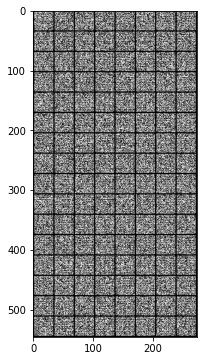

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        filters = [ndf*4, ndf*8,ndf*16,nchannels]
        padding = [1,1,0]
        stride = [2,2,1]
        last_layer = [False,False,True]
        use_batch_norm = [True,True,False]
        self.rest = nn.Sequential(*[get_downscaling_block(channels_in = filters[x-1],
                                                           channels_out = filters[x],
                                                           kernel = 4,
                                                           stride = stride[x-1],
                                                           padding = padding[x-1],
                                                           use_batch_norm=use_batch_norm[x-1],
                                                           is_last = last_layer[x-1]) for x in range(1,len(filters))])
     

        #                 #
        ###################
        
    def forward(self, x, y):
        y = y.unsqueeze(2).unsqueeze(2)
        y = y.expand(x.shape[0],y.shape[1],x.shape[2],x.shape[3])
        x = self.downscale_x(x)
        y = self.downscale_y(y)
        x = torch.cat((x,y),1)
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        
        
        y = F.one_hot(labels).float().to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z_train = sample_z(cur_batch_size,nz)
        # 2. Generate a fake image
        fakeIm = netG(z_train,y)
        # 3. Classify real image with D
        yhat_real = netD(im,y)
        # 4. Classify fake image with D
        yhat_fake = netD(fakeIm,y)
        
        
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,get_labels_one(cur_batch_size)) 
        d_loss += criterion(yhat_fake,get_labels_zero(cur_batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        yhat_fake = netD(fakeIm,y)
        g_loss = criterion(yhat_fake,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
            

## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

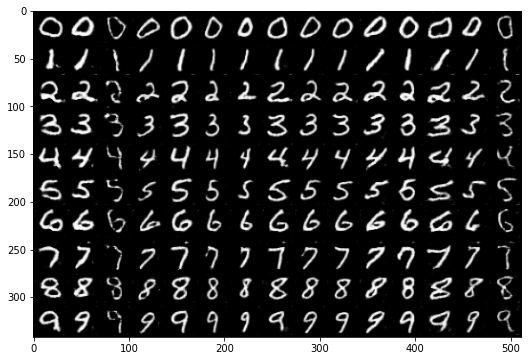

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)  

plt.imshow(pil_grid)
plt.show()
